In [1]:
import nest
import random
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from scipy.signal import hilbert
from scipy import signal
import time
from ipywidgets import interactive,interact, HBox, Layout,VBox
from scipy.signal import find_peaks
#%run "../PC-PV-SOM/Setup.ipynb"
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import nest.raster_plot
font1={'family':'Times New Roman',
'weight':'bold',
'size': 14}

SOM_neurons = 20
ChAT_neurons = 25
iMSN_neurons = 565
N_neurons = SOM_neurons + ChAT_neurons + iMSN_neurons
neuron_locations = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/neuron_locations_PLVPSD.txt')
position = np.array([0.5, 0.5])
spon_ref = np.array([8.229565217,6.629166667,0.390782609])
stim_ref = np.array([4.206086957, 9.559166667,0.638521739])
da_ref = np.array([4.293913043, 9.454166667,0.676565217])

property_dict = {
    
    # all are organised as numpy arrays
    # The first element to the last corresponds to DA, SOM, ChAT and iMSN respectively
    # The first elements was meant for DA neurons but omitted and set to 0.
    # Some data are extracted from :https://www.neuroelectro.org/ephys_prop/
    "membrane_time_constant": np.array([0., 20., 17.8, 5.98 ]), # unit : milisecond
    "capacitance": np.array([0.,165.0, 169.5, 36.4]), # unit: pF
    "resistance" : np.array([121.21,  105.01,  95.527]), # unit in MOhm
    "excitatory_synaptic_time_constant" : np.array([0, 3.50, 2.5, 3.0]), # unit: milisecond
    "inhibitory_synaptic_time_constant": np.array([0, 5.0, 2.5, 3.0]), # unit: milisecond
    "refactory_time": np.array([0, 2.0, 2.0, 2.0, 2.0]), # unit: milisecond
}

def plv(spikes, HT,  HT_org):
    
    spikes = spikes[spikes<8000]
    sample_num = 1000   # sample_num: Number of spikes used to compute plv
    if len(spikes) >= 1:
        
        if len(spikes) >= sample_num:
            spikes = np.unique(random.sample(list(spikes), sample_num))
        
        spikes = list(map(int,spikes))
        
        instantaneous_phases_beta = np.angle(HT[spikes]) # instantaneous phases at spike time of beta oscillations
        instantaneous_phases_LFP = np.angle(HT_org[spikes])
        mid_exp = np.exp(instantaneous_phases_LFP * 1j)
        phase_locking_value = np.abs((mid_exp / np.abs(mid_exp)).mean())
        
        # convert into the range (0, 2pi]
        idx = np.where(instantaneous_phases_beta < 0.) 
        instantaneous_phases_beta[idx] = instantaneous_phases_beta[idx] + 2 * np.pi * np.ones(len(idx))
        
    else:
        phase_locking_value = []
        instantaneous_phases_beta = []

    return phase_locking_value, instantaneous_phases_beta


def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True, show_mean = True, amp = 1.2):

    # Wrap angles to [-pi, pi)
    data = x
    
    x_mean = np.angle(np.exp(data * 1j).mean())
    #r_mean = abs(sum(np.exp(data * 1j)))
    
    x = (x+np.pi) % (2*np.pi) - np.pi
    
    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)
    
    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    #patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
    #                 edgecolor='C0', fill=False, linewidth=1)
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths, color='.8',
                      edgecolor = None,  linewidth=1)
    if show_mean:
        theta = [x_mean, x_mean]
        r = [0, radius.mean()]
        #r2 = [0, amp*radius.mean()]
        ax.plot(theta, r,'r')
        print(x_mean)
        #ax.plot(theta, r2,alpha=0.01)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])
        
    #ax.set_ylim(0,amp)

    return n, bins, patches, x_mean, radius.mean()

def plot_circular_histogram_and_plv(ChAT_phases, iMSN_phases, density = True, show_mean = True, amp=1.2):

    fig, axs = plt.subplots(1,2, subplot_kw = dict(projection = 'polar'),figsize=(12,4))
    n, bins, patches, ChAT_mean,ChAT_frequency=circular_hist(axs[0], ChAT_phases, offset = 0, density = density, show_mean = show_mean,amp=amp)
    n, bins, patches, iMSN_mean,iMSN_frequency=circular_hist(axs[1], iMSN_phases, offset = 0, density = density, show_mean = show_mean,amp=amp)
    return ChAT_mean,iMSN_mean,ChAT_frequency,iMSN_frequency


def compute_LFP3(position, neuron_locations, I_syn_ex, I_syn_in, SOM_neurons, ChAT_neurons, iMSN_neurons):
    
    tsp = I_syn_ex.shape[1]
    
    local_field_potentials = np.zeros(tsp)
    N_neurons = SOM_neurons + ChAT_neurons + iMSN_neurons
    
    for n in range(N_neurons):

        distance = np.linalg.norm(neuron_locations[n,::] - position)
        current = I_syn_ex[n,::] + I_syn_in[n,::]
        local_field_potentials = local_field_potentials + current /(distance * 4 * np.pi * 0.3 * 1e6)
        
    return local_field_potentials

def set_connection_dict(c1, c2, c3, c4,c5,c6, c9, c10, c11, c12, 
                        c7, c8, c13, c14, c15, c16, c17,c20, pfM, pfC, wMM, sig, cpCC):
    
    connection_dict = {

    
    # All arrays' first element was meant for DA neurons but omitted and set to 0.
    # stores the probability of the connections come from SOM neurons to SOM, ChAT, iMSN
        "SOM": np.array([0.01, c14, c15]), 
    
    # stores the probability of the connections come from ChAT neurons to SOM, ChAT, iMSN
        "ChAT": np.array([0, cpCC, c1]), 
    
    # stores the probability of the connections come from iMSN neurons to SOM, ChAT, iMSN
        "iMSN": np.array([0, c2, c20]), 
    
    # stores the synaptic weights
        'synaptic_weights' : np.array([[0.0, 0.0, 0.0, 0.0],
                                       [ 0.00, -5.60, c16, c17],
                                       [ 0.00,  0.00,  2.00,  c3],
                                       [ 0.00,  0.00, c4, wMM]]),
    
        'tsodyks2_synapse_U': np.array([[0.00, 0.00, 0.00, 0.00],
                                        [0.06, 0.06, 0.50, 0.30],
                                        [0.50, 0.50, 0.50, 0.50],
                                        [0.30, 0.30, 0.30, 0.30]]),
    
        'tsodyks2_synapse_tau_fac': np.array([[0.0,  0.0,  0.0,  0.0 ],
                                              [50.0, 50.0, 50.0, 50.0],
                                              [375., 375., 375., 375.],
                                              [150., 150., 150., 150.]]),
    
        'tsodyks2_synapse_tau_rec': np.array([[0.00, 0.00, 0.00, 0.00],
                                              [100., 100., 100., 100.],
                                              [80.0, 80.0, 80.0, 80.0],
                                              [100., 100., 100., 100.]]),
    }

    conn_dict_SOMtoSOM = {'rule': 'pairwise_bernoulli', 'p': connection_dict['SOM'][0]}
    conn_dict_SOMtoChAT = {'rule': 'pairwise_bernoulli', 'p': connection_dict['SOM'][1]}
    conn_dict_SOMtoiMSN = {'rule': 'pairwise_bernoulli', 'p': connection_dict['SOM'][2]}

    conn_dict_ChATtoChAT = {'rule': 'pairwise_bernoulli', 'p': connection_dict['ChAT'][1]}
    conn_dict_ChATtoiMSN = {'rule': 'pairwise_bernoulli', 'p': connection_dict['ChAT'][2]}
    
    conn_dict_iMSNtoChAT = {'rule': 'pairwise_bernoulli', 'p': connection_dict['iMSN'][1]}
    conn_dict_iMSNtoiMSN = {'rule': 'pairwise_bernoulli', 'p': connection_dict['iMSN'][2]}
    
    syn_dict_SOMtoSOM = {"delay": {"distribution":'normal_clipped',
                            'mu': c7, 'sigma': sig,
                            'low': 0.5}, "weight":connection_dict['synaptic_weights'][1,1], 
               "model": "tsodyks2_synapse",
               "U":connection_dict['tsodyks2_synapse_U'][1,1],
               "tau_fac":connection_dict['tsodyks2_synapse_tau_fac'][1,1],
               "tau_rec":connection_dict['tsodyks2_synapse_tau_rec'][1,1]}
    
    syn_dict_SOMtoChAT = {"delay": {"distribution":'normal_clipped',
                            'mu': c8, 'sigma': sig,
                            'low': 0.5}, 
                          "weight":connection_dict['synaptic_weights'][1,2], 
               "model": "tsodyks2_synapse",
               "U":connection_dict['tsodyks2_synapse_U'][1,2],
               "tau_fac":connection_dict['tsodyks2_synapse_tau_fac'][1,2],
               "tau_rec":connection_dict['tsodyks2_synapse_tau_rec'][1,2]}
    
    syn_dict_SOMtoiMSN = {"delay": {"distribution":'normal_clipped',
                            'mu': c13, 'sigma': sig,
                            'low': 0.5},
                          "weight":connection_dict['synaptic_weights'][1,3], 
               "model": "tsodyks2_synapse",
               "U":connection_dict['tsodyks2_synapse_U'][1,3],
               "tau_fac":connection_dict['tsodyks2_synapse_tau_fac'][1,3],
               "tau_rec":connection_dict['tsodyks2_synapse_tau_rec'][1,3]}
    
    syn_dict_ChATtoChAT = {"delay": {"distribution":'normal_clipped',
                            'mu': c11, 'sigma': sig,
                            'low': 0.5},
                           "weight":connection_dict['synaptic_weights'][2,2], 
               "model": "tsodyks2_synapse",
               "U":connection_dict['tsodyks2_synapse_U'][2,2],
               "tau_fac":connection_dict['tsodyks2_synapse_tau_fac'][2,2],
               "tau_rec":connection_dict['tsodyks2_synapse_tau_rec'][2,2]}
    
    syn_dict_ChATtoiMSN = {"delay": {"distribution":'normal_clipped',
                            'mu': c12, 'sigma': sig,
                            'low': 0.5},
                           "weight":connection_dict['synaptic_weights'][2,3], 
               "model": "tsodyks2_synapse",
               "U":connection_dict['tsodyks2_synapse_U'][2,3],
               "tau_fac":connection_dict['tsodyks2_synapse_tau_fac'][2,3],
               "tau_rec":connection_dict['tsodyks2_synapse_tau_rec'][2,3]}
    
    syn_dict_iMSNtoChAT = {"delay": {"distribution":'normal_clipped',
                            'mu': c9, 'sigma': sig,
                            'low': 0.5},
                           "weight":connection_dict['synaptic_weights'][3,2], 
               "model": "tsodyks2_synapse",
               "U":connection_dict['tsodyks2_synapse_U'][3,2],
               "tau_fac":connection_dict['tsodyks2_synapse_tau_fac'][3,2],
               "tau_rec":connection_dict['tsodyks2_synapse_tau_rec'][3,2]}
    
    syn_dict_iMSNtoiMSN = {"delay": {"distribution":'normal_clipped',
                            'mu': c10, 'sigma': sig,
                            'low': 0.5},
                           "weight":connection_dict['synaptic_weights'][3,3], 
               "model": "tsodyks2_synapse",
               "U":connection_dict['tsodyks2_synapse_U'][3,3],
               "tau_fac":connection_dict['tsodyks2_synapse_tau_fac'][3,3],
               "tau_rec":connection_dict['tsodyks2_synapse_tau_rec'][3,3]}
    
    # set poisson input frequency and strength
    spontaneous_dict = {
                        "possion_frequency": np.array([0., 8000., pfC, pfM]),  # unit: Hz
                        "possion_weight": np.array([0., 1.59, c5, c6]),
                        }
    
    # To make the return line short
    a = conn_dict_SOMtoSOM
    b = conn_dict_SOMtoChAT
    c = conn_dict_SOMtoiMSN
    d = conn_dict_ChATtoChAT
    e = conn_dict_ChATtoiMSN
    f = conn_dict_iMSNtoChAT
    g = conn_dict_iMSNtoiMSN
    h = syn_dict_SOMtoSOM
    i = syn_dict_SOMtoChAT
    j = syn_dict_SOMtoiMSN
    k = syn_dict_ChATtoChAT
    l = syn_dict_ChATtoiMSN
    m = syn_dict_iMSNtoChAT
    n = syn_dict_iMSNtoiMSN
    o = spontaneous_dict
    
    return  a,b,c,d,e,f,g,h,i,j,k,l,m,n, o


[INFO] [2022.4.17 14:40:19 /home/conda/feedstock_root/build_artifacts/nest-simulator_1636957218381/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2022.4.17 14:40:19 /home/conda/feedstock_root/build_artifacts/nest-simulator_1636957218381/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Nov 15 2021 06:24:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
SOM_random_amp = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/SOM_random_amp.txt')
ChAT_random_amp = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/ChAT_random_amp.txt')
iMSN_random_amp = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/iMSN_random_amp.txt')
SOM_cap = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/SOM_cap.txt')
ChAT_cap = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/ChAT_cap.txt')
iMSN_cap = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/iMSN_cap.txt')

SOM_tau = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/SOM_tau.txt')
ChAT_tau = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/ChAT_tau.txt')
iMSN_tau = np.loadtxt('/home/wzl/LFPy/oscillation/large_synatic_time_constant/neuron-property/iMSN_tau.txt')

In [4]:

def StimThreeGroupsHist(simu_time=8000, stimu_tstart=40*1000,stimu_tend=80*1000, light_SOM = -6.04,light_iMSN = 0.0,light_ChAT = 0.0 , pfM = 6000.0 , pfC = 7200.0 ,  pfS = 7300.0, 
    cpCM = 0.44 , cpMC = 0.16 , wCM = 2.04 , wMC = -8.9 , pC = 3.3 , pM = 1.48 , 
    sMC = 3.7 , sMM = 22.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
    cpSM = 0.58 , wSC = -10.8 , wSM = -10.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
    rnum = 360 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
    pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5 , 
    pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
    ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 3.0, iMSN_tau_syn_in = 3.0, seed=10):

    """
    cpCM = 0.44, cpMC = 0.16, 
         wCM = 1.71, wMC = -8.15, pC = 2.75, pM =2.79,
         sMC = 5.6, sMM = 7.4, sCC=4.4, sCM = 4.3,
         sSS =5.6, sSC=1.6, sSM = 1.4, cpSC = 0.4,
        cpSM = 0.48, wSC = -9.20, wSM = -9.2, light = -3.8,
        upfilter = 80, cpMM = 0.6, amp = 2, rnum = 360, pfM = 6250., pfC = 6900., wMM = -8.85,
        mtcM = 17.02, capM = 105.
    """
    
    """
    cpCM = 0.30, cpMC = 0.06, 
         wCM = 2.0, wMC = -5.4, pC = 2.08, pM =1.77,
         sMC = 5.6, sMM = 7.4, sCC=4.4, sCM = 4.3,
         sSS =5.6, sSC=1.6, sSM = 1.4, cpSC = 0.24,
        cpSM = 0.32, wSC = -11.0, wSM = -6.4, light = -3.8,
        upfilter = 80, cpMM = 0.4, amp = 2, rnum = 360, pfM = 7000., pfC = 9000., wMM = -5.4,
        mtcM = 5.98, capM = 36.4, tsuM = 0.30, tstfM = 150., tstrM = 100.,
                        mtcC = 17.8, capC = 169.5
    """
    """
    cpCM = 0.30, c2 = 0.06, c3 = 2.0, c4 = -5.4, 
              c5=2.08, c6=1.77, c9=5.60, c10= 7.40, c11 = 4.4, c12 = 4.3, c7 = 5.6,
               c8 = 1.6, c13 = 1.4, c14 = 0.24, c15 = 0.32, c16 = -11.0, c17 = -6.4,
                        c18 = -3.8, c19 = 80, c20 = 0.40, c21 = 2, c22 = 360
    """


    sim_time=simu_time
    # in order to put the activity under spontaneous state and SOM inhibition together
    stim_tstart = stimu_tstart
    stim_tend = stimu_tend

    property_dict = {

    # all are organised as numpy arrays
    # The first element to the last corresponds to DA, SOM, ChAT and iMSN respectively
    # The first elements was meant for DA neurons but omitted and set to 0.
    # Some data are extracted from :https://www.neuroelectro.org/ephys_prop/
    #"membrane_time_constant": np.array([0., 20., 17.8, mtcM ]), # unit: milisecond
    #"capacitance": np.array([0.,165.0, 169.5, capM]), # unit: pF
    #"resistance" : np.array([121.21,  105.01,  mtcM / capM * 1e3]), # unit: MOhm
    "excitatory_synaptic_time_constant" : np.array([0, 3.50, 2.5, 3.0]), # unit: milisecond
    "inhibitory_synaptic_time_constant": np.array([0, 5.0, 2.5, 3.0]), # unit: milisecond
    "refactory_time": np.array([0, 2.0, 2.0, 2.0, 20.0]), # unit: milisecond
    }

    nest.ResetKernel()
    nest.SetKernelStatus({"resolution": 0.5,'biological_time': 0.})

    # create all the nodes representing point neurons
    N_neurons = SOM_neurons + ChAT_neurons + iMSN_neurons
    nodes = nest.Create("iaf_psc_alpha", N_neurons)
    SOM_nodes = nodes[:SOM_neurons]
    ChAT_nodes = nodes[SOM_neurons : SOM_neurons + ChAT_neurons]
    iMSN_nodes = nodes[SOM_neurons + ChAT_neurons :]

    # set neurons' properties using property dictionary    
    nest.SetStatus(SOM_nodes, {#"tau_m":property_dict['membrane_time_constant'][1] ,
                            "t_ref":property_dict['refactory_time'][1], 
                            #"C_m":property_dict['capacitance'][1],
                            "I_e": 0.,
                            "tau_syn_ex": SOM_tau_syn_ex,
                            "tau_syn_in": SOM_tau_syn_in})

    nest.SetStatus(ChAT_nodes, {#"tau_m":property_dict['membrane_time_constant'][2] ,
                            "t_ref":property_dict['refactory_time'][2], 
                            #"C_m":property_dict['capacitance'][2],
                            "I_e": 0.,
                            "tau_syn_ex":ChAT_tau_syn_ex,
                            "tau_syn_in": ChAT_tau_syn_in})

    nest.SetStatus(iMSN_nodes, {#"tau_m":property_dict['membrane_time_constant'][3] ,
                            "t_ref":property_dict['refactory_time'][3], 
                            #"C_m":property_dict['capacitance'][3],
                            "I_e": 0.,
                            "tau_syn_ex":iMSN_tau_syn_ex,
                            "tau_syn_in": iMSN_tau_syn_in})

    for n in range(SOM_neurons):
        nest.SetStatus(SOM_nodes[n - 1:n], {"tau_m": SOM_tau[n],
                                            "C_m": SOM_cap[n]})
        
    for n in range(ChAT_neurons):
        nest.SetStatus(ChAT_nodes[n - 1:n], {"tau_m": ChAT_tau[n],
                                            "C_m": ChAT_cap[n]})

    for n in range(iMSN_neurons):
        nest.SetStatus(iMSN_nodes[n - 1:n], {"tau_m": iMSN_tau[n],
                                            "C_m": iMSN_cap[n]})

    # create devices to record the neurons' voltage trace and synaptic currents and accurate spike times
    multimeter = nest.Create("multimeter", N_neurons,params={'record_from': ['V_m', 'I_syn_ex','I_syn_in',
                                                                            'weighted_spikes_ex',
                                                                            'weighted_spikes_in']})


    SOM_spd = nest.Create("spike_detector",  SOM_neurons, params={"withgid":True,"withtime":True})
    ChAT_spd = nest.Create("spike_detector", ChAT_neurons, params={"withgid":True,"withtime":True})
    iMSN_spd = nest.Create("spike_detector", iMSN_neurons, params={"withgid":True,"withtime":True}) 

    allSOM_spd = nest.Create("spike_detector", params={"withgid":True,"withtime":True})
    allChAT_spd = nest.Create("spike_detector", params={"withgid":True,"withtime":True})
    allMSN_spd = nest.Create("spike_detector", params={"withgid":True,"withtime":True})
    nest.Connect(SOM_nodes, allSOM_spd, 'all_to_all')
    nest.Connect(ChAT_nodes, allChAT_spd, 'all_to_all')
    nest.Connect(iMSN_nodes, allMSN_spd, 'all_to_all')

    # connect the devices onto the neurons
    nest.Connect(multimeter, nodes, 'one_to_one')

    dc_SOM = nest.Create("dc_generator")
    nest.SetStatus(dc_SOM, [{"amplitude": light_SOM, "start": 1.0*stim_tstart, "stop":  1.0*stim_tend }])
    nest.Connect(dc_SOM, SOM_nodes, "all_to_all")

    dc_iMSN = nest.Create("dc_generator")
    nest.SetStatus(dc_iMSN, [{"amplitude": light_iMSN, "start": 1.0*stim_tstart, "stop":  1.0*stim_tend }])
    nest.Connect(dc_iMSN, iMSN_nodes, "all_to_all")


    dc_ChAT = nest.Create("dc_generator")
    nest.SetStatus(dc_ChAT, [{"amplitude": light_ChAT, "start": 1.0*stim_tstart, "stop":  1.0*stim_tend }])
    nest.Connect(dc_ChAT, ChAT_nodes, "all_to_all")


    nest.Connect(SOM_nodes,SOM_spd, 'one_to_one')
    nest.Connect(ChAT_nodes, ChAT_spd, 'one_to_one')
    nest.Connect(iMSN_nodes, iMSN_spd, 'one_to_one')


    a,b,c,d,e,f,g,h,i,j,k,l,m,n,o = set_connection_dict(cpCM, cpMC, wCM, wMC , pC, pM,
        sMC, sMM, sCC, sCM, sSS, sSC, sSM, cpSC, cpSM , wSC, wSM, cpMM, pfM, pfC, wMM, sig,cpCC)

    conn_dict_SOMtoSOM = a
    conn_dict_SOMtoChAT = b
    conn_dict_SOMtoiMSN = c  
    conn_dict_ChATtoChAT = d
    conn_dict_ChATtoiMSN =e
    conn_dict_iMSNtoChAT = f
    conn_dict_iMSNtoiMSN = g
    syn_dict_SOMtoSOM = h
    syn_dict_SOMtoChAT = i
    syn_dict_SOMtoiMSN = j   
    syn_dict_ChATtoChAT = k
    syn_dict_ChATtoiMSN = l
    syn_dict_iMSNtoChAT = m
    syn_dict_iMSNtoiMSN = n
    spontaneous_dict = o

    nest.Connect(SOM_nodes, SOM_nodes, conn_dict_SOMtoSOM, syn_dict_SOMtoSOM)
    nest.Connect(SOM_nodes, ChAT_nodes, conn_dict_SOMtoChAT, syn_dict_SOMtoChAT)
    nest.Connect(SOM_nodes, iMSN_nodes, conn_dict_SOMtoiMSN, syn_dict_SOMtoiMSN)

    nest.Connect(ChAT_nodes, ChAT_nodes, conn_dict_ChATtoChAT, syn_dict_ChATtoChAT)
    nest.Connect(ChAT_nodes, iMSN_nodes, conn_dict_ChATtoiMSN, syn_dict_ChATtoiMSN)

    nest.Connect(iMSN_nodes, ChAT_nodes, conn_dict_iMSNtoChAT, syn_dict_iMSNtoChAT)
    nest.Connect(iMSN_nodes, iMSN_nodes, conn_dict_iMSNtoiMSN, syn_dict_iMSNtoiMSN)

    # create poisson generators and connect to neurons
    noise_ex_SOM = nest.Create("poisson_generator", SOM_neurons)
    #nest.SetStatus(noise_ex_SOM, {"rate": spontaneous_dict['possion_frequency'][1]})
    #syn_dict_ex_SOM = {"weight": spontaneous_dict['possion_weight'][1]}
    nest.SetStatus(noise_ex_SOM, {"rate": pfS})
    syn_dict_ex_SOM = {"weight": wpfS}
    nest.Connect(noise_ex_SOM,SOM_nodes,'one_to_one',syn_spec = syn_dict_ex_SOM)

    noise_ex_ChAT = nest.Create("poisson_generator", ChAT_neurons)
    nest.SetStatus(noise_ex_ChAT, {"rate":  spontaneous_dict['possion_frequency'][2]})
    syn_dict_ex_ChAT = {"weight":  spontaneous_dict['possion_weight'][2]}
    nest.Connect(noise_ex_ChAT, ChAT_nodes, 'one_to_one',syn_spec = syn_dict_ex_ChAT)

    noise_ex_iMSN = nest.Create("poisson_generator", iMSN_neurons)

    noise_in_SOM = nest.Create("poisson_generator", SOM_neurons)
    #nest.SetStatus(noise_ex_SOM, {"rate": spontaneous_dict['possion_frequency'][1]})
    #syn_dict_ex_SOM = {"weight": spontaneous_dict['possion_weight'][1]}
    nest.SetStatus(noise_in_SOM, {"rate": pfSin})
    syn_dict_in_SOM = {"weight": wpfSin}
    nest.Connect(noise_in_SOM,SOM_nodes,'one_to_one',syn_spec = syn_dict_in_SOM)


    noise_in_ChAT = nest.Create("poisson_generator", ChAT_neurons)
    nest.SetStatus(noise_in_ChAT, {"rate": pfCin})
    syn_dict_in_ChAT = {"weight":  wpfCin}
    nest.Connect(noise_in_ChAT, ChAT_nodes, 'one_to_one',syn_spec = syn_dict_in_ChAT)


    noise_in_iMSN = nest.Create("poisson_generator", iMSN_neurons)

    nest.SetStatus(noise_in_iMSN, {"rate": pfMin})
    syn_dict_in_iMSN = {"weight":  wpfMin}
    nest.Connect(noise_in_iMSN, iMSN_nodes, 'one_to_one', syn_spec = syn_dict_in_iMSN)

    nest.SetStatus(noise_ex_iMSN[:rnum], {"rate": spontaneous_dict['possion_frequency'][3]})
    nest.Connect(noise_ex_iMSN[:rnum],iMSN_nodes[:rnum], 'one_to_one',
                    syn_spec = {"weight": spontaneous_dict['possion_weight'][3]})


    rn = np.loadtxt('/home/wzl/LFPy/oscillation/large-delay/neuron-property/random_number.txt')
    for n in range(rnum + 1,iMSN_neurons):
        nest.SetStatus(noise_ex_iMSN[n - 1:n], {"rate": rn[n - rnum - 1]
                                                * spontaneous_dict['possion_frequency'][3]})
        nest.Connect(noise_ex_iMSN[n-1:n],iMSN_nodes[n-1:n], 
                    syn_spec = {"weight": (amp-rn[n - rnum - 1]) * spontaneous_dict['possion_weight'][3]})
        

    nest.Simulate(sim_time)

    rates = np.array([len(nest.GetStatus(allSOM_spd,keys='events')[0]['times']) / sim_time / SOM_neurons * 1e3,
                    len(nest.GetStatus(allChAT_spd,keys='events')[0]['times']) / sim_time / ChAT_neurons * 1e3,
                    len(nest.GetStatus(allMSN_spd,keys='events')[0]['times']) / sim_time / iMSN_neurons * 1e3])

    DM = nest.GetStatus(multimeter) 
    ts = len(DM[0]["events"]["times"]) + 1
    I_syn_ex = np.zeros((N_neurons, ts))
    I_syn_in = np.zeros((N_neurons, ts))

    for n in range(N_neurons): 

        I_syn_ex[n,1:] = DM[n]["events"]["I_syn_ex"]
        I_syn_in[n,1:] = DM[n]["events"]["I_syn_in"]

        
        # 70 mV / 208 MOhm = 0.336 1e-3 V / 1e6 Ohm = 0.336 * 1e-9 A = 336 pA = 70 / 208 * 1e3 pA

    LFP = compute_LFP3(position, neuron_locations, I_syn_ex, I_syn_in,
                SOM_neurons, ChAT_neurons, iMSN_neurons)
    # LFP = compute_LFP3(position, neuron_locations[SOM_neurons : SOM_neurons + ChAT_neurons,::], I_syn_ex[SOM_neurons : SOM_neurons + ChAT_neurons,1:], I_syn_in[SOM_neurons : SOM_neurons + ChAT_neurons,1:],
    #                0, ChAT_neurons, 0)               
                            


    b,a = signal.cheby2(N = 4, rs = 36, Wn = [12.5 / 500., 30. / 500.], btype = 'bandpass')
    b2,a2 = signal.cheby2(N = 4, rs = 36, Wn = [1. / 500., 200. / 500.], btype = 'bandpass')
    beta_LFP = signal.filtfilt(b,a, LFP) # filter out beta band oscillations
    filterLFP = signal.filtfilt(b2,a2, LFP)  # filter out LFP between 1 and 200 Hz


    HT = hilbert(beta_LFP)  # compute hilbert transformation
    HT_org = hilbert(filterLFP)

    ChAT_phases = []
    iMSN_phases = []
    ChAT_plv = []
    iMSN_plv = []
    record_ChAT = []
    record_iMSN = []
    record_ChAT_phases = dict()
    record_iMSN_phases = dict()
    all_ChAT_phases = dict()
    all_iMSN_phases = dict()

    for idx in range(ChAT_neurons):
        ChAT_spike= nest.GetStatus(ChAT_spd, keys='events')[idx]['times']
        mid1, mid2 = plv(ChAT_spike, HT,  HT_org)
        if len(mid2):
            ChAT_plv = np.hstack((ChAT_plv,mid1))
            all_ChAT_phases[str(idx)] = mid2
            
            if 180 * np.pi / 180. <= mid2.mean() <= 270. * np.pi / 180:
                
                record_ChAT = np.hstack((record_ChAT, idx))
                record_ChAT_phases[str(idx)] = mid2
            
            ChAT_phases = np.hstack((ChAT_phases, mid2))


    for idx in range(iMSN_neurons):
        iMSN_spike= nest.GetStatus(iMSN_spd, keys='events')[idx]['times']
        mid1, mid2 = plv(iMSN_spike, HT,  HT_org)
        if len(mid2):
            iMSN_plv = np.hstack((iMSN_plv,mid1))
            all_iMSN_phases[str(idx)] = mid2
            if 270 * np.pi / 180. <= mid2.mean() <= 360. * np.pi / 180.:
                record_iMSN = np.hstack((record_iMSN, idx))
                record_iMSN_phases[str(idx)] = mid2
                
            iMSN_phases = np.hstack((iMSN_phases, mid2))

    # np.savetxt('record_ChAT.txt', record_ChAT)
    # np.savetxt('record_iMSN.txt', record_iMSN)
    # np.savetxt('StimChAT_phases3.txt', ChAT_phases)
    # np.savetxt('StimiMSN_phases3.txt', iMSN_phases)

    plt.figure(figsize=(15,7))
    plt.subplot(2,3,1)
    pxx2, freqs = plt.psd(LFP[:100],  NFFT = 1024,  Fs = 1000, scale_by_freq = True, noverlap = 250)


    bins = int(len(LFP) / 320)
    for b in range(1, bins):
        start = 320 * b
        end = 320 * (b + 1)
        mid_pxx, mid_freq = plt.psd(LFP[start:end],  NFFT = 1024,
                                    Fs = 1000, scale_by_freq = True, noverlap = 250)
        pxx2 = np.vstack((pxx2, mid_pxx))

    pxx2_mean = pxx2.mean(0)


    #np.savetxt('StimPxx_mean3.txt', pxx2_mean)
    #np.savetxt('StimPxx_freq3.txt', freqs)

    plt.subplot(2,3,2)
    plt.plot(freqs, pxx2_mean,'r',label = 'After Stimulus')
    plt.legend()  
    plt.title('Power Spectral Density (dB/Hz)')
    plt.xlabel('Frequency')
    plt.xlim(xmin = 2, xmax = 70)
    plt.axvline(x=20, linestyle = '--')
    freqs0=freqs

    plt.subplot(2,3,3)
    spec,freqs, t, cax = plt.specgram(LFP, NFFT = 800,Fs = 1000, scale = 'linear' ,
                                    scale_by_freq = True, noverlap = 500)
    #np.savetxt('StimSpec4.txt', spec)
    #np.savetxt('StimFreq4.txt', freqs)
    plt.ylim(ymin = 2, ymax = 40)
    plt.xlabel('Time (s)')

    plt.subplot(2,3,4)
    plt.scatter(['SOM','ChAT','iMSN'],stim_ref,c='r', marker='x', label='Experiments')
    plt.scatter(['SOM','ChAT','iMSN'], rates, c = 'b', label = 'Simulation')
    plt.ylabel('Frequency')


    plt.subplot(2,3,(5,6))
    plt.plot(np.linspace(30000.,4000.,1000),LFP[3000:4000])
    plt.title('Local Field Potential')
    plt.xlabel('Time (ms)')

    plt.figure(2)
    for i in range(iMSN_neurons):
        plt.scatter(nest.GetStatus(iMSN_spd,keys='events')[i]['times'],i*np.ones_like(nest.GetStatus(iMSN_spd,keys='events')[i]['times']),color='mediumpurple',alpha=0.3,s=10)
    for i in range(ChAT_neurons):
        plt.scatter(nest.GetStatus(ChAT_spd,keys='events')[i]['times'],i*np.ones_like(nest.GetStatus(ChAT_spd,keys='events')[i]['times']),color='mediumseagreen',alpha=0.3,s=10)
    #     plt.xlim([51000,52000])
    # plt.xlim([51000,52000])

    ChAT_mean,iMSN_mean,ChAT_frequency,iMSN_frequency=plot_circular_histogram_and_plv(ChAT_phases, iMSN_phases, density = True)

    print(rates)
    return ChAT_phases,iMSN_phases, record_ChAT_phases, record_iMSN_phases, ChAT_spd, iMSN_spd, LFP, beta_LFP, allChAT_spd, allMSN_spd, all_ChAT_phases, all_iMSN_phases,freqs0, pxx2_mean, rates, ChAT_mean,iMSN_mean,ChAT_frequency,iMSN_frequency

In [19]:
# plot the phase lock 
font2={'family':'Times New Roman',
'weight':'bold',
'size': 14}
def plot_phase_lock(ChAT_phases,iMSN_phases):
    fig, axs = plt.subplots(1,2, subplot_kw = dict(projection = 'polar'),figsize=(12,5))
    bins=16
    # ChAT
    phase_mean0 = np.angle(np.exp(ChAT_phases * 1j).mean())
    fre0, bins0 = np.histogram(ChAT_phases, bins=bins)
    widths0 = np.diff(bins0)
    radius0 = fre0
    patches=axs[0].bar(bins0[:-1], radius0, zorder=1, align='edge', width=widths0, color='mediumseagreen',alpha=0.6,
                      edgecolor = None,  linewidth=1)
   
    theta0 = [phase_mean0, phase_mean0]
    r0 = [0, radius0.mean()]
    axs[0].plot(theta0, r0,'k',linewidth=2)
    axs[0].set_xticks(np.arange(0,2*np.pi,1/6*np.pi))
    axs[0].set_yticks(np.arange(100,300,100))
    axs[0].set_ylim([0,300])
    # iMSN
    phase_mean1 = np.angle(np.exp(iMSN_phases * 1j).mean())
    fre1, bins1 = np.histogram(iMSN_phases, bins=bins)
    widths1 = np.diff(bins1)
    radius1 = fre1
    patches=axs[1].bar(bins1[:-1], radius1, zorder=1, align='edge', width=widths1, color='mediumpurple',alpha=0.6,
                      edgecolor = None,  linewidth=1)
   
    theta1 = [phase_mean1, phase_mean1]
    r1 = [0, radius1.mean()]
    axs[1].plot(theta1, r1,'k',linewidth=2)
    axs[1].set_xticks(np.arange(0,2*np.pi,1/6*np.pi))
    axs[1].set_yticks(np.arange(100,300,100))
    # axs[1].set_yticks(np.arange(500,2000,500))
    axs[1].set_ylim([0,300])
    # plt.savefig('phase_lock_ON.eps')
    # axs[1].set_yticks(np.arange(200,800,200))
    # axs[1].set_ylim([0,600])
    # plt.savefig('phase_lock_OFF.eps')

In [16]:
np.savetxt('ChAT_phases_inhSOM_tau.txt', ChAT_phases_inhSOM)
np.savetxt('iMSN_phases_inhSOM_tau.txt', iMSN_phases_inhSOM)
np.savetxt('ChAT_phases_spon_tau.txt', ChAT_phases_spon)
np.savetxt('iMSN_phases_spon_tau.txt', iMSN_phases_spon)


Apr 17 15:51:35 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Apr 17 15:51:35 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Apr 17 15:51:35 Network::create_rngs_ [Info]: 
    Creating default RNGs

Apr 17 15:51:35 Network::create_grng_ [Info]: 
    Creating new default global RNG

Apr 17 15:51:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Apr 17 15:51:35 NodeManager::prepare_nodes [Info]: 
    Preparing 3056 nodes for simulation.

Apr 17 15:51:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3056
    Simulation time (ms): 8000
    Number of OpenMP threads: 1
    Not using MPI

Apr 17 15:51:45 SimulationManager::run [Info]: 
    Simulation finished.
-2.8242203141863564
-0.10925917409104048
[ 3.50625    10.63        1.26150442]


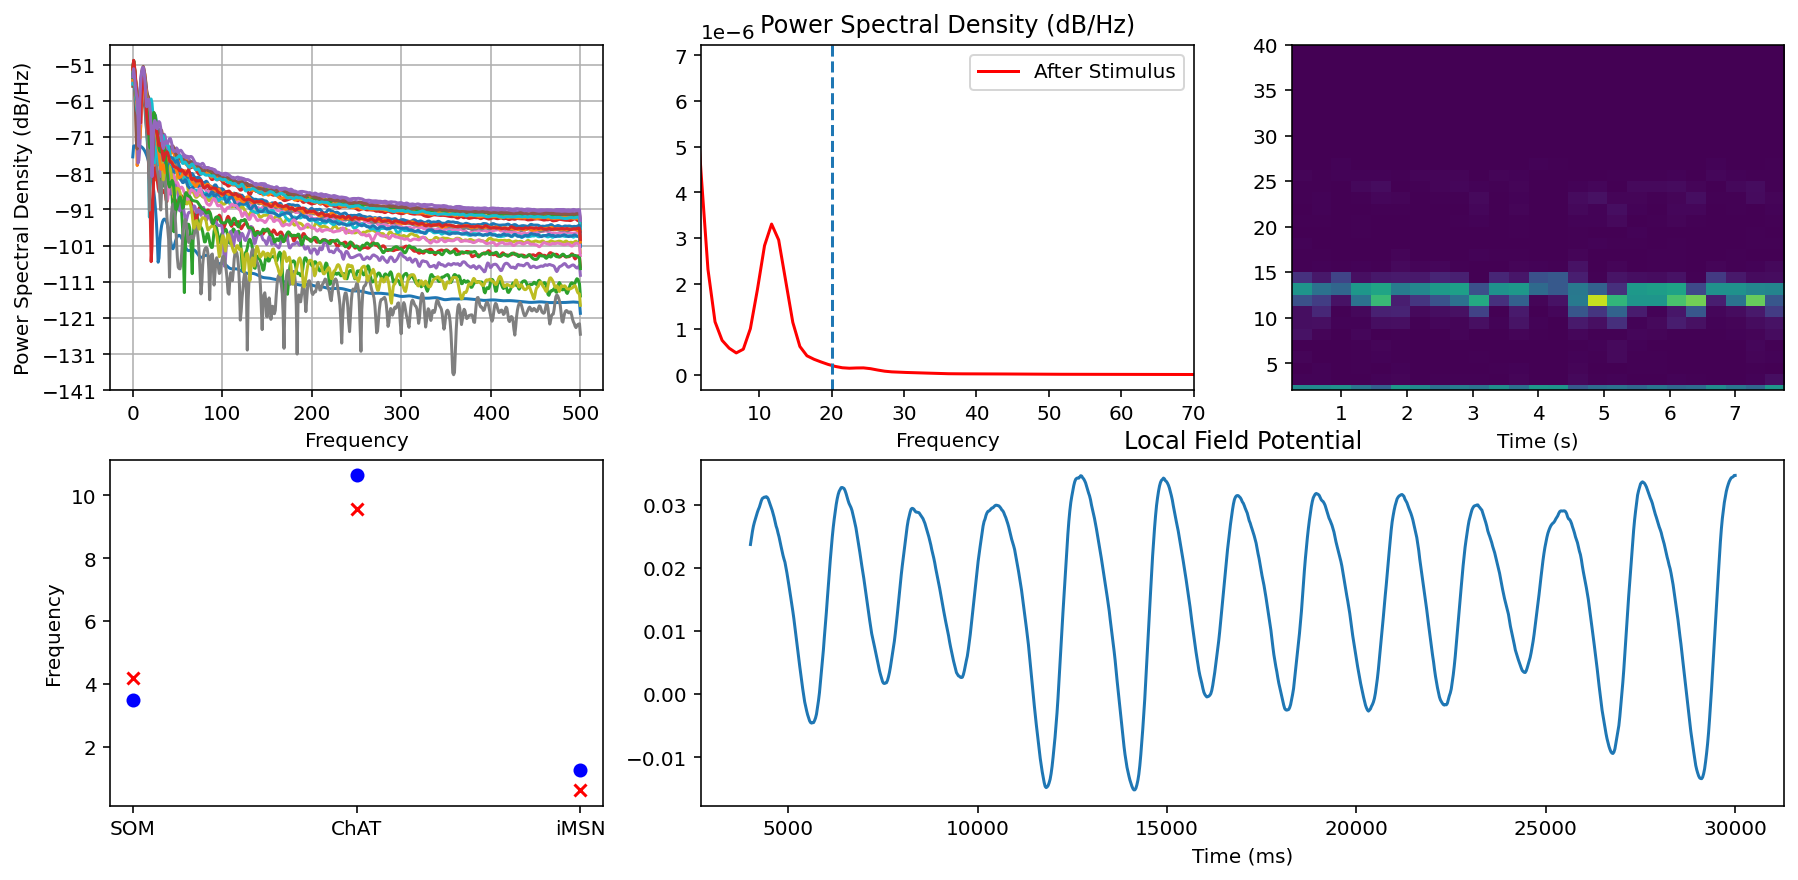

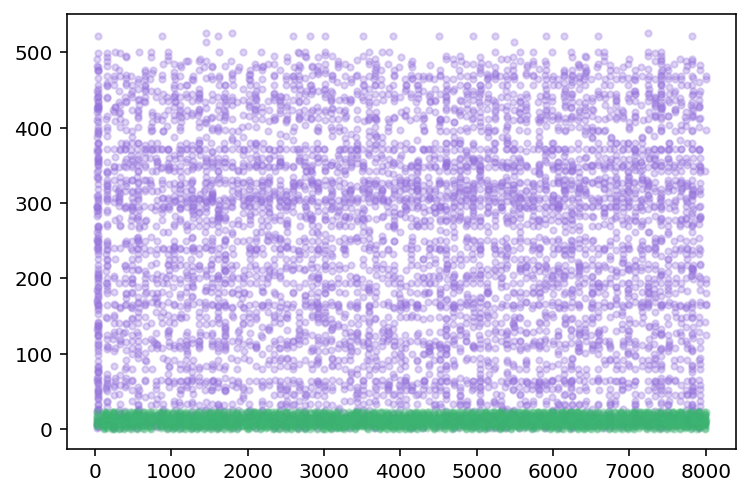

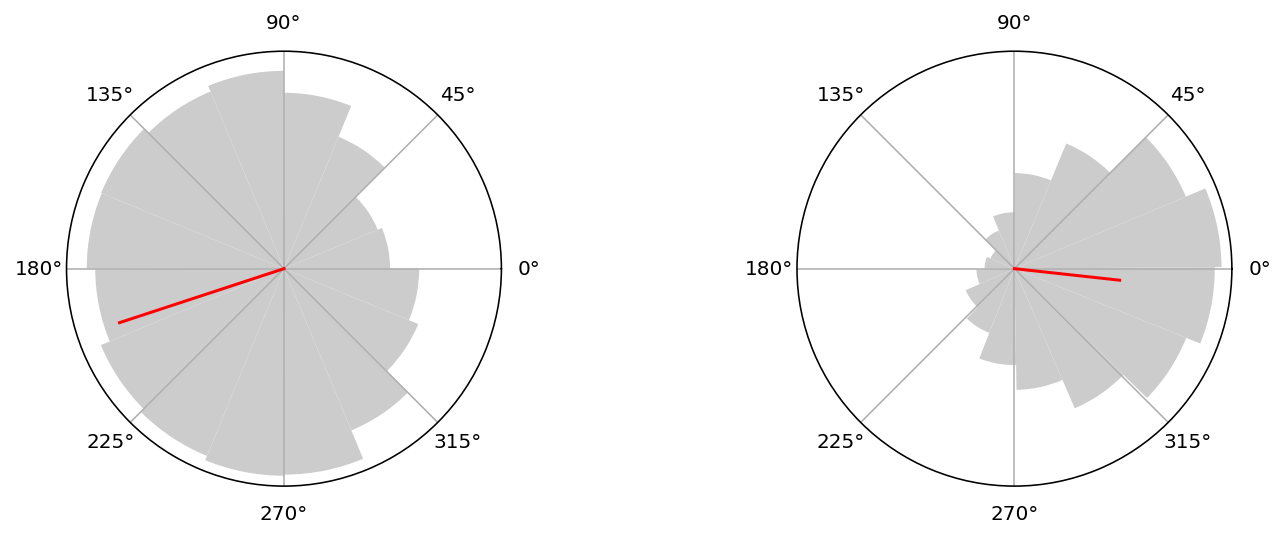

In [14]:
ChAT_phases_inhSOM,iMSN_phases_inhSOM,record_ChAT_phases_inhSOM, record_iMSN_phases_inhSOM, ChAT_spd_inhSOM, iMSN_spd_inhSOM, LFP_inhSOM, beta_LFP_inhSOM, allChAT_spd_inhSOM, allMSN_spd_inhSOM, all_ChAT_phases_inhSOM, all_iMSN_phases_inhSOM,freqs_inhSOM, pxx2_mean_inhSOM, rates_inhSOM,ChAT_mean_inhSOM,iMSN_mean_inhSOM,ChAT_frequency_inhSOM,iMSN_frequency_inhSOM = StimThreeGroupsHist(simu_time=8*1000,stimu_tstart=0*1000, stimu_tend=8*1000, light_SOM = -22.04, pfM = 8000.0 , pfC = 8700.0 ,  pfS = 8200.0, 
    cpCM = 0.44 , cpMC = 0.86 , wCM = 2.04 , wMC = -50.9 , pC = 3.3 , pM = 1.48 , 
    sMC = 3.7 , sMM = 2.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
    cpSM = 0.58 , wSC = -10.8 , wSM = -30.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
    rnum = 500 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
    pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5 ,
    pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
    ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 2.5, iMSN_tau_syn_in = 10.4, seed=1000 )


Apr 15 11:22:18 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Apr 15 11:22:18 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Apr 15 11:22:18 Network::create_rngs_ [Info]: 
    Creating default RNGs

Apr 15 11:22:18 Network::create_grng_ [Info]: 
    Creating new default global RNG

Apr 15 11:22:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Apr 15 11:22:18 NodeManager::prepare_nodes [Info]: 
    Preparing 3056 nodes for simulation.

Apr 15 11:22:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3056
    Simulation time (ms): 8000
    Number of OpenMP threads: 1
    Not using MPI

Apr 15 11:22:27 SimulationManager::run [Info]: 
    Simulation finished.
-2.7187838993071507
-0.10986791208940908
[3.01875    7.415      1.38362832]


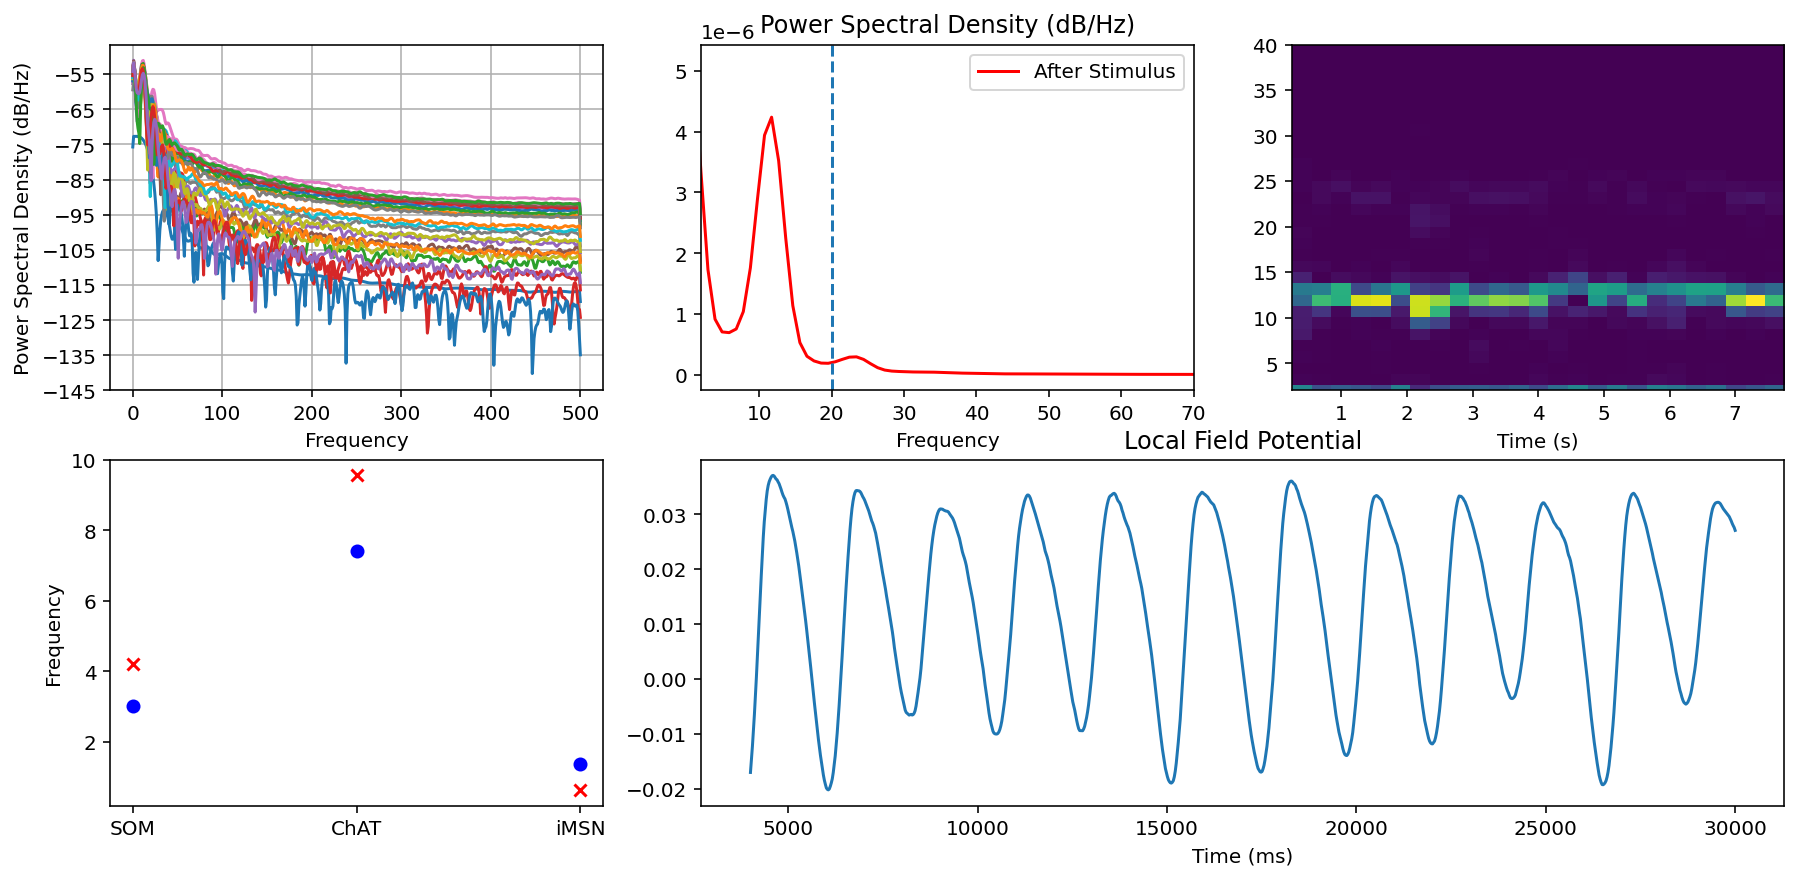

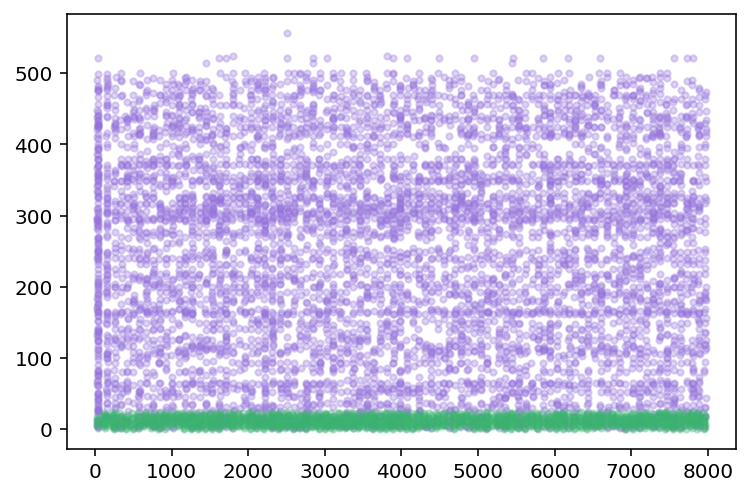

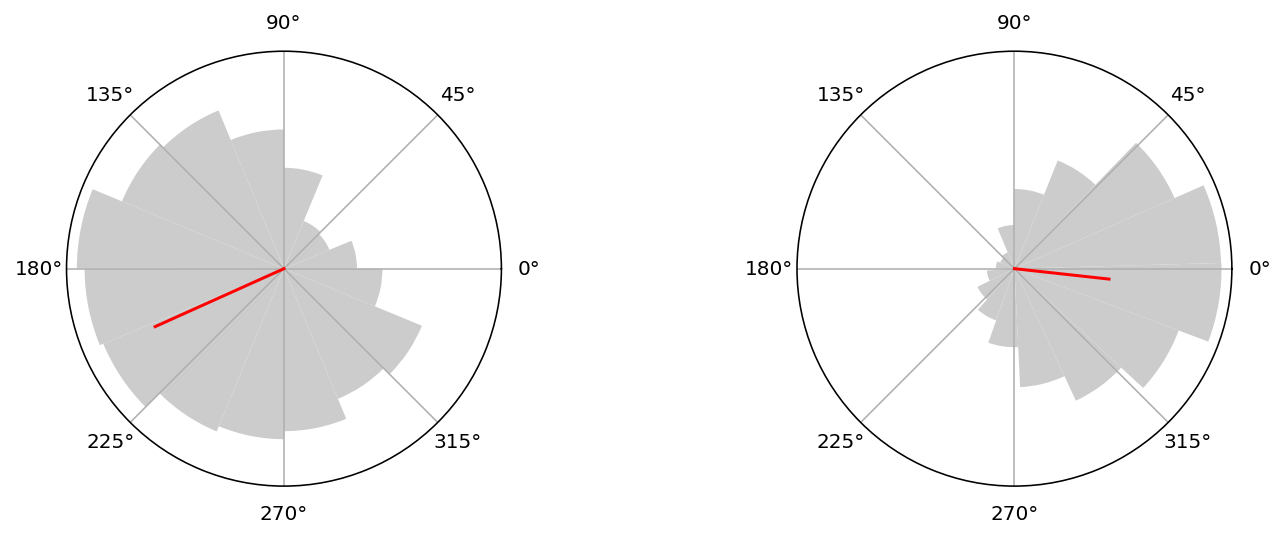

In [20]:
# ChAT_phases_inhDA,iMSN_phases_inhDA,record_ChAT_phases_inhDA, record_iMSN_phases_inhDA, ChAT_spd_inhDA, iMSN_spd_inhDA, LFP_inhDA, beta_LFP_inhDA, allChAT_spd_inhDA, allMSN_spd_inhDA, all_ChAT_phases_inhDA, all_iMSN_phases_inhDA,freqs_inhDA, pxx2_mean_inhDA, rates_inhDA,ChAT_mean_inhDA,iMSN_mean_inhDA,ChAT_frequency_inhDA,iMSN_frequency_inhDA = StimThreeGroupsHist(simu_time=8*1000,stimu_tstart=0*1000, stimu_tend=8*1000, light_SOM = 0.00, pfM = 8100.0 , pfC = 8200.0 ,  pfS = 6700.0, 
#     cpCM = 0.44 , cpMC = 0.86 , wCM = 2.04 , wMC = -50.9 , pC = 3.3 , pM = 1.48 , 
#     sMC = 3.7 , sMM = 2.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
#     cpSM = 0.58 , wSC = -10.8 , wSM = -30.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
#     rnum = 500 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
#     pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5,
#     pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
#     ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 2.5, iMSN_tau_syn_in = 10.4, seed=1000 )


Apr 17 18:52:46 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Apr 17 18:52:46 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Apr 17 18:52:46 Network::create_rngs_ [Info]: 
    Creating default RNGs

Apr 17 18:52:46 Network::create_grng_ [Info]: 
    Creating new default global RNG

Apr 17 18:52:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Apr 17 18:52:47 NodeManager::prepare_nodes [Info]: 
    Preparing 3056 nodes for simulation.

Apr 17 18:52:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3056
    Simulation time (ms): 8000
    Number of OpenMP threads: 1
    Not using MPI

Apr 17 18:53:08 SimulationManager::run [Info]: 
    Simulation finished.
-0.9712058126770198
0.29779797684265524
[12.8375     14.6         0.49513274]


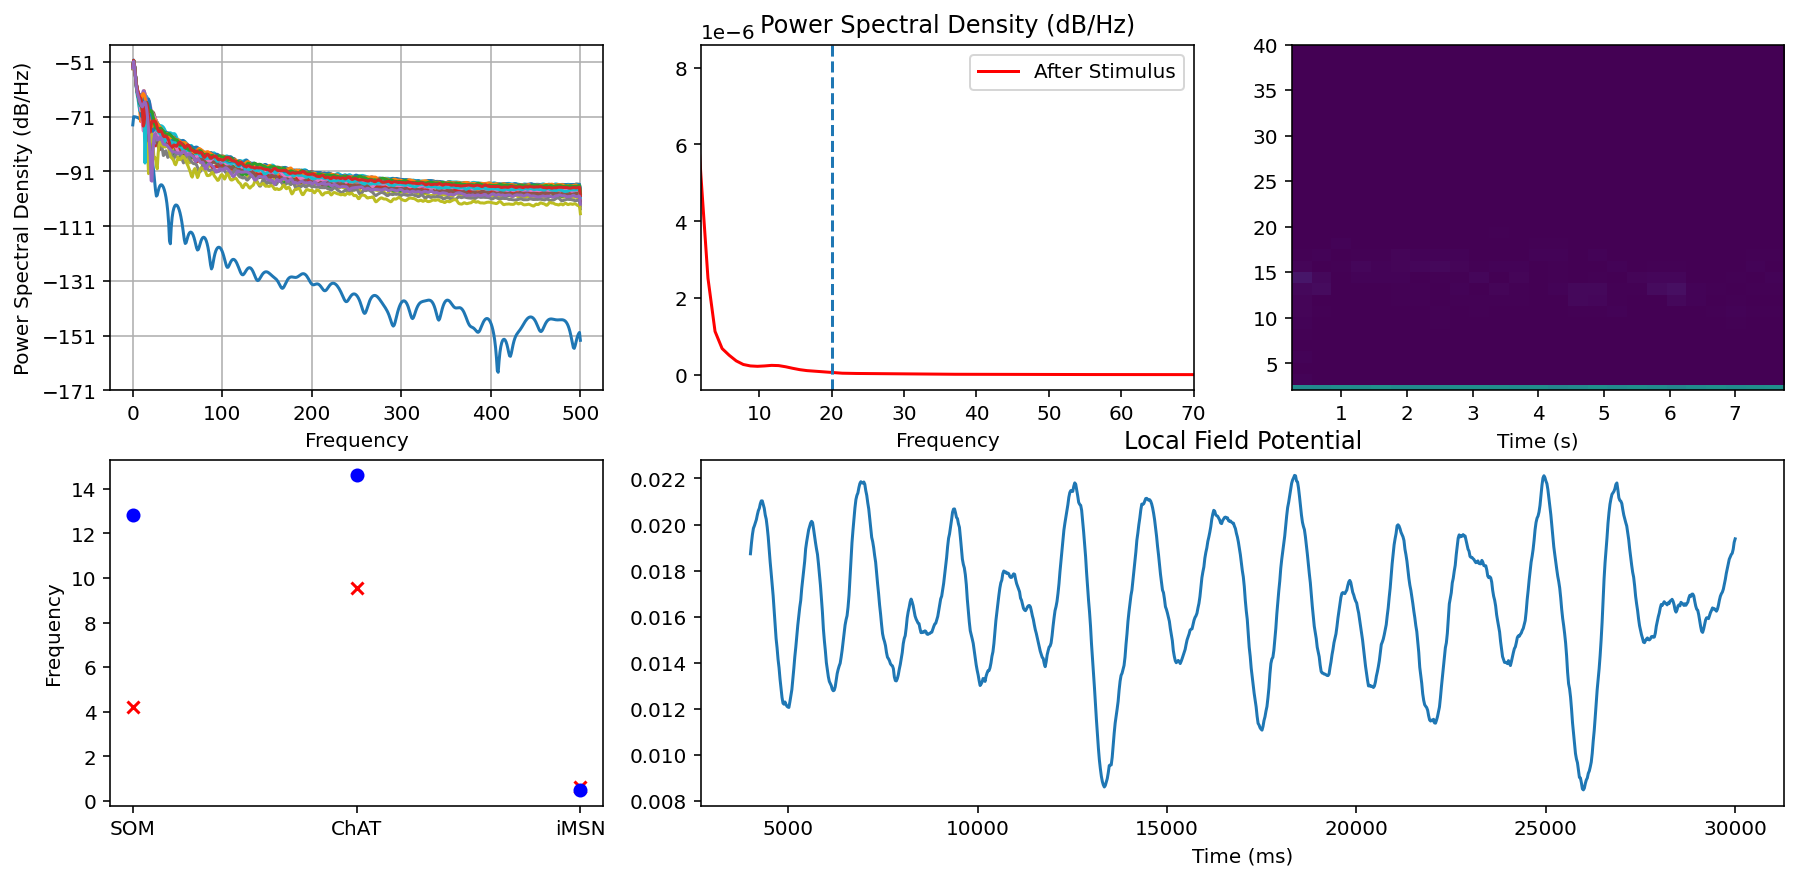

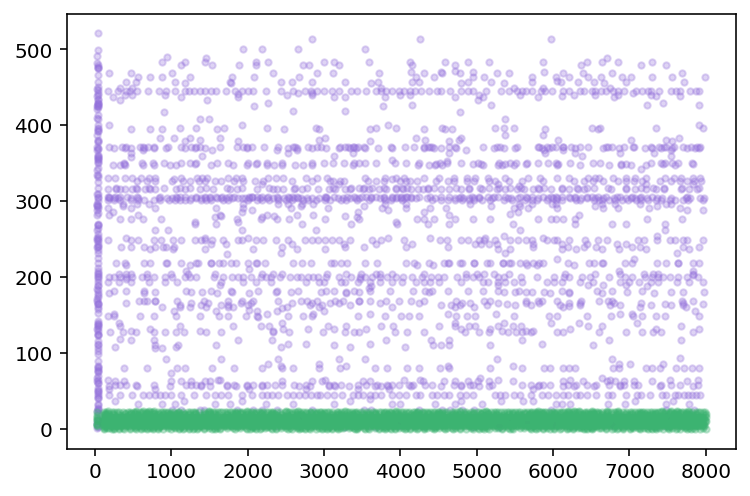

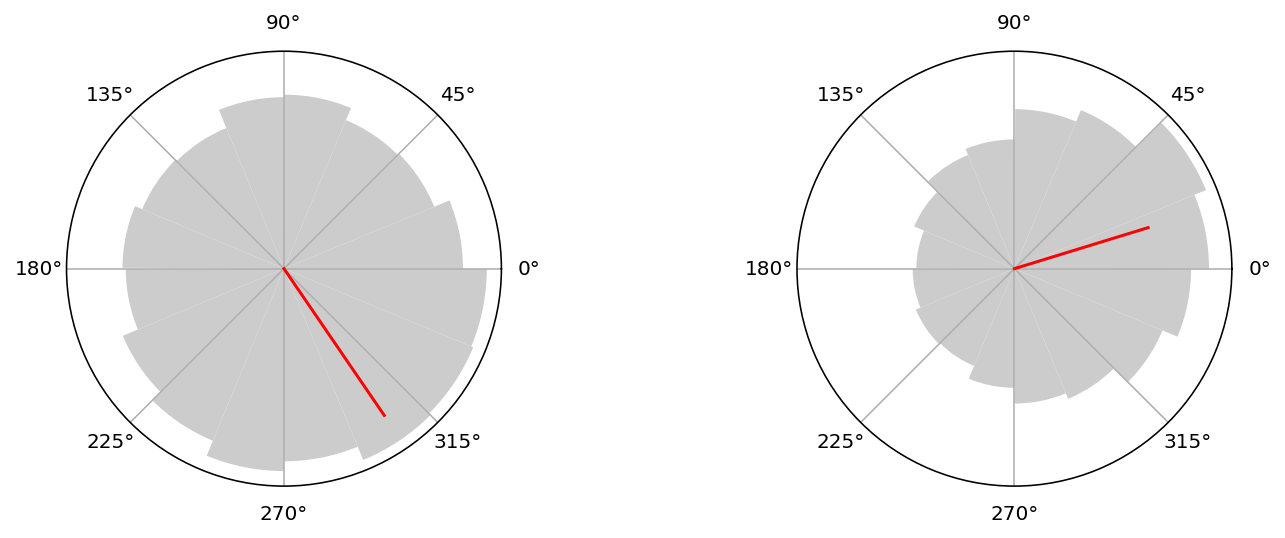

In [27]:
ChAT_phases_spon,iMSN_phases_spon,record_ChAT_phases_spon, record_iMSN_phases_spon, ChAT_spd_spon, iMSN_spd_spon, LFP_spon, beta_LFP_spon, allChAT_spd_spon, allMSN_spd_spon, all_ChAT_phases_spon, all_iMSN_phases_spon,freqs_spon, pxx2_mean_spon, rates_spon,ChAT_mean_spon,iMSN_mean_spon,ChAT_frequency_spon,iMSN_frequency_spon = StimThreeGroupsHist(simu_time=8*1000,stimu_tstart=0*1000,stimu_tend=8*1000, light_SOM = 0.00, pfM = 8000.0 , pfC = 8700.0 ,  pfS = 8200.0, 
    cpCM = 0.44 , cpMC = 0.86 , wCM = 2.04 , wMC = -50.9 , pC = 3.3 , pM = 1.48 , 
    sMC = 3.7 , sMM = 2.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
    cpSM = 0.58 , wSC = -10.8 , wSM = -30.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
    rnum = 500 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
    pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5 ,
    pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
    ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 2.5, iMSN_tau_syn_in = 10.4, seed=1000 )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


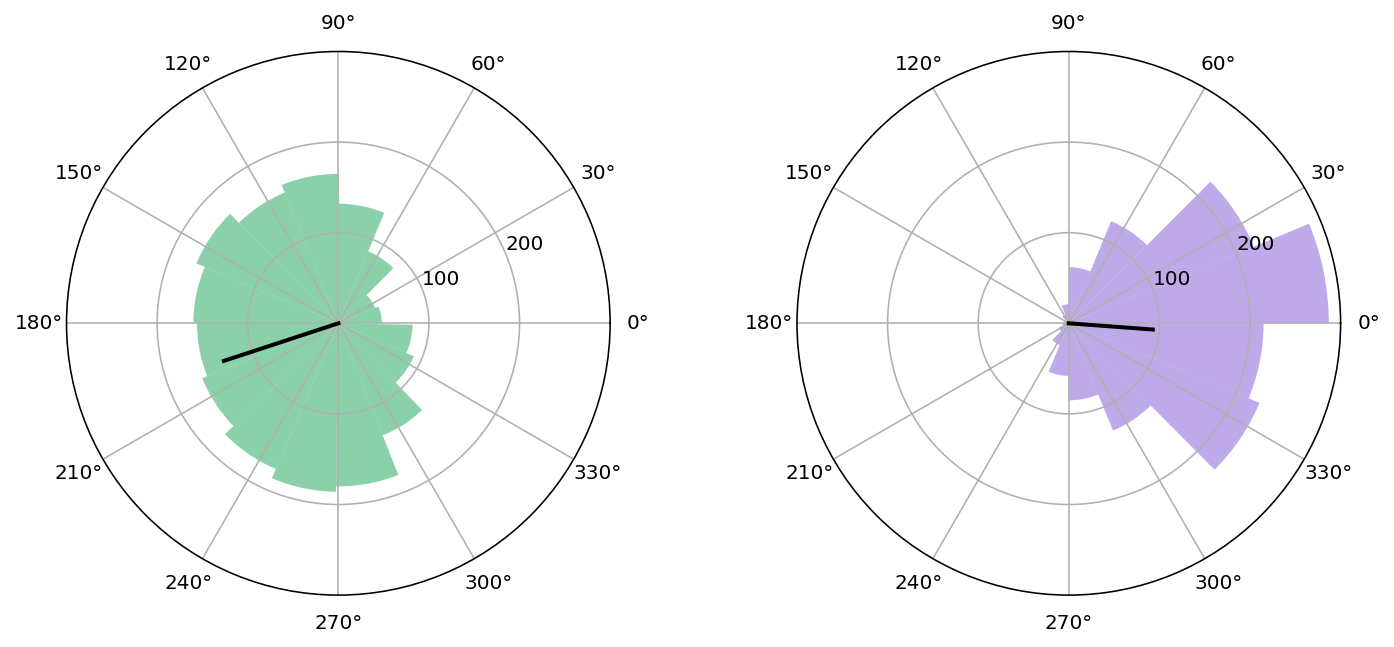

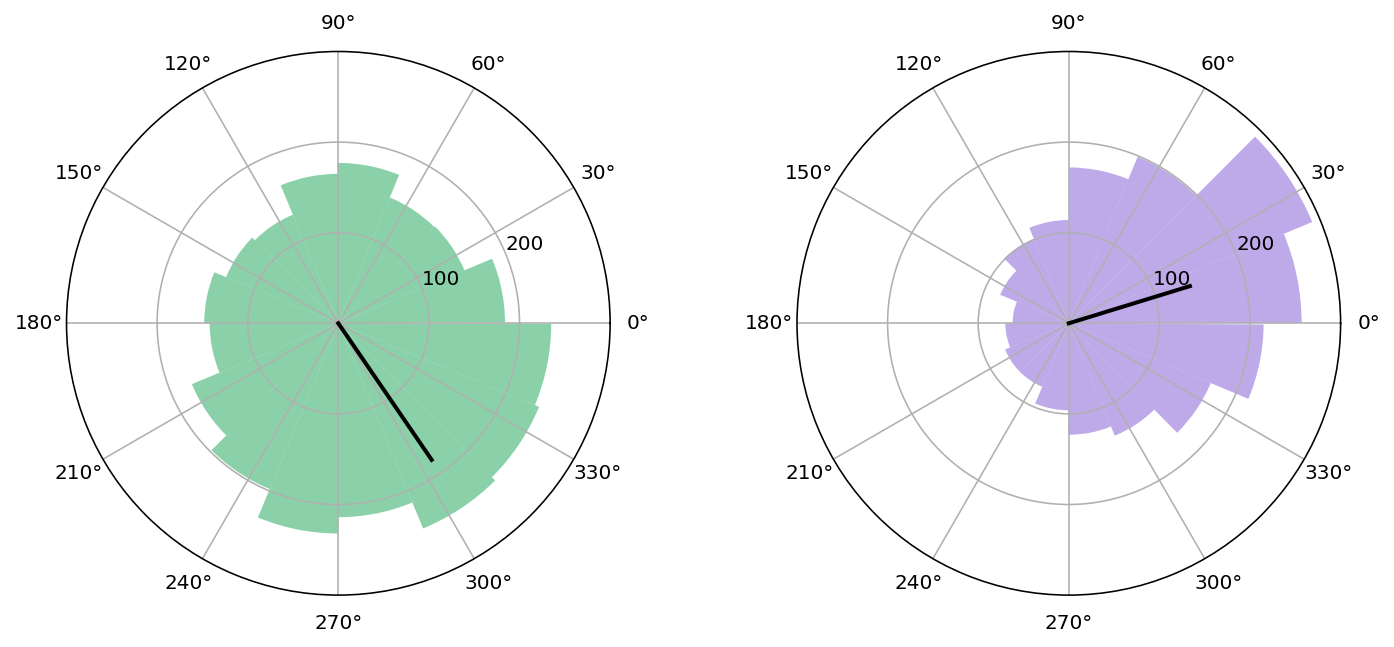

In [24]:
# phase-locking
plot_phase_lock(ChAT_phases_inhSOM,iMSN_phases_inhSOM[:int(len(ChAT_phases_inhSOM)*0.7)])
plt.savefig('phase_lock_inhSOM.eps')
# plot_phase_lock(ChAT_phases_inhDA,iMSN_phases_inhDA[:len(ChAT_phases_inhDA)])
# # plt.savefig('phase_lock_inhDA.eps')
plot_phase_lock(ChAT_phases_spon,iMSN_phases_spon[:len(ChAT_phases_spon)])
plt.savefig('phase_lock_spon.eps')


Apr 17 17:57:56 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Apr 17 17:57:56 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Apr 17 17:57:56 Network::create_rngs_ [Info]: 
    Creating default RNGs

Apr 17 17:57:56 Network::create_grng_ [Info]: 
    Creating new default global RNG

Apr 17 17:57:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Apr 17 17:57:57 NodeManager::prepare_nodes [Info]: 
    Preparing 3056 nodes for simulation.

Apr 17 17:57:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3056
    Simulation time (ms): 80000
    Number of OpenMP threads: 1
    Not using MPI

Apr 17 18:01:31 SimulationManager::run [Info]: 
    Simulation finished.
-1.055988639794358
0.2833505448812682
[ 7.995625   12.462       0.87969027]


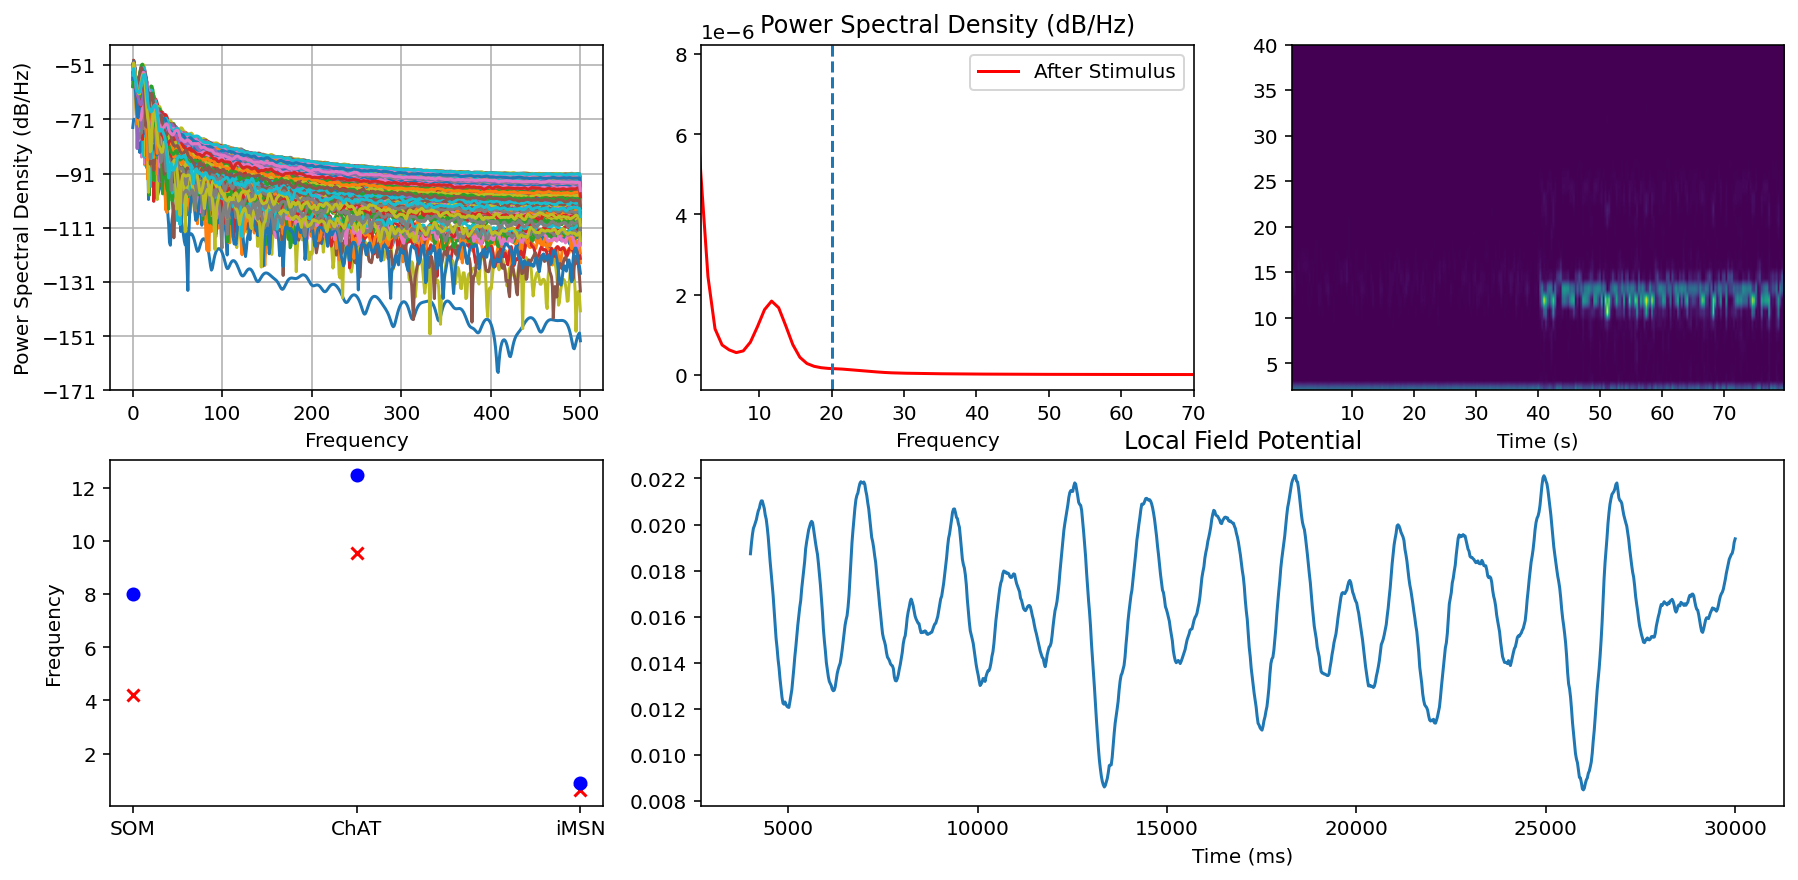

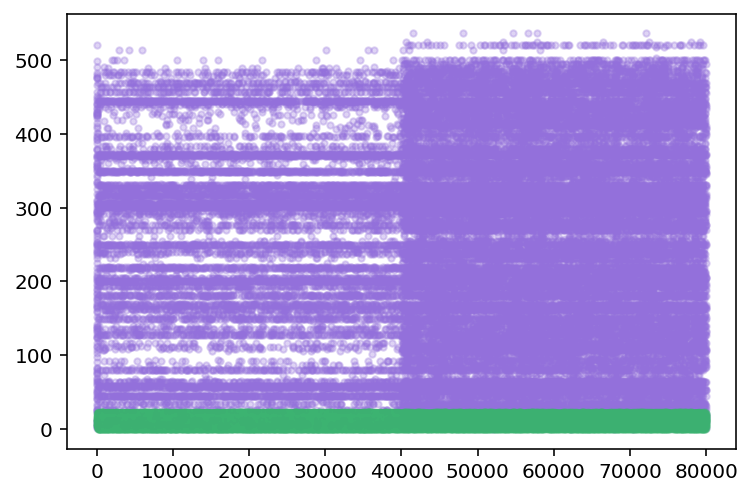

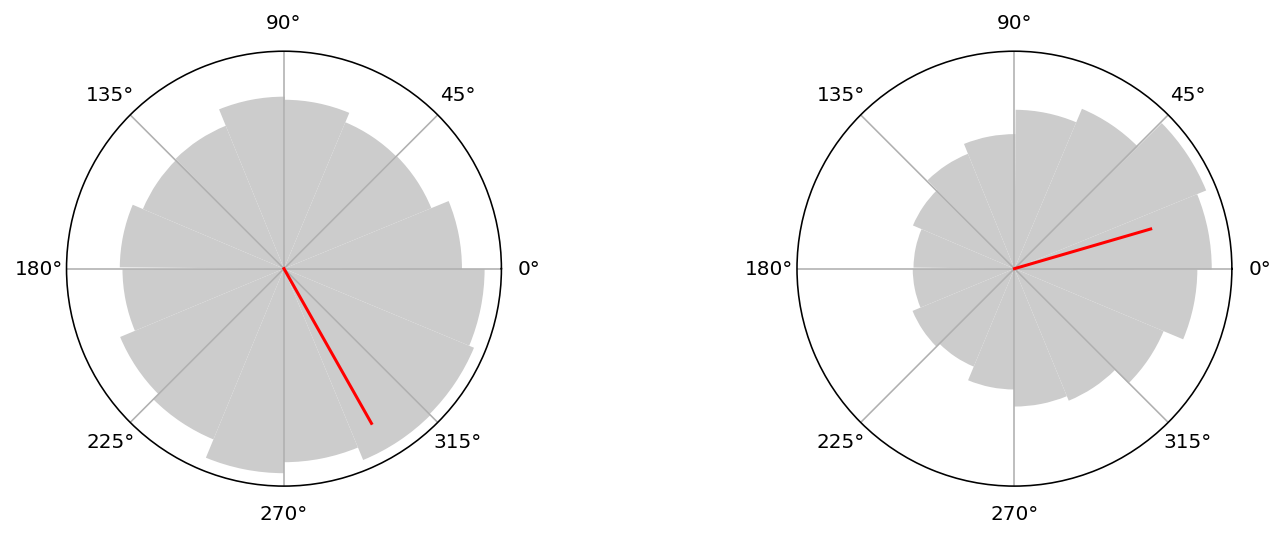

In [25]:
ChAT_phases_inhSOM1,iMSN_phases_inhSOM1,record_ChAT_phases_inhSOM1, record_iMSN_phases_inhSOM1, ChAT_spd_inhSOM1, iMSN_spd_inhSOM1, LFP_inhSOM1, beta_LFP_inhSOM1, allChAT_spd_inhSOM1, allMSN_spd_inhSOM1, all_ChAT_phases_inhSOM1, all_iMSN_phases_inhSOM1,freqs_inhSOM1, pxx2_mean_inhSOM1, rates_inhSOM1,ChAT_mean_inhSOM1,iMSN_mean_inhSOM1,ChAT_frequency_inhSOM1,iMSN_frequency_inhSOM1 = StimThreeGroupsHistChAT_phases_spon,iMSN_phases_spon,record_ChAT_phases_spon, record_iMSN_phases_spon, ChAT_spd_spon, iMSN_spd_spon, LFP_spon, beta_LFP_spon, allChAT_spd_spon, allMSN_spd_spon, all_ChAT_phases_spon, all_iMSN_phases_spon,freqs_spon, pxx2_mean_spon, rates_spon,ChAT_mean_spon,iMSN_mean_spon,ChAT_frequency_spon,iMSN_frequency_spon = StimThreeGroupsHist(simu_time=80*1000,stimu_tstart=40*1000,stimu_tend=80*1000, light_SOM = -22.40, pfM = 8000.0 , pfC = 8700.0 ,  pfS = 8200.0, 
    cpCM = 0.44 , cpMC = 0.86 , wCM = 2.04 , wMC = -50.9 , pC = 3.3 , pM = 1.48 , 
    sMC = 3.7 , sMM = 2.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
    cpSM = 0.58 , wSC = -10.8 , wSM = -30.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
    rnum = 500 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
    pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5 ,
    pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
    ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 2.5, iMSN_tau_syn_in = 10.4, seed=1000 )



Apr 17 18:59:04 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Apr 17 18:59:04 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Apr 17 18:59:04 Network::create_rngs_ [Info]: 
    Creating default RNGs

Apr 17 18:59:04 Network::create_grng_ [Info]: 
    Creating new default global RNG

Apr 17 18:59:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Apr 17 18:59:05 NodeManager::prepare_nodes [Info]: 
    Preparing 3056 nodes for simulation.

Apr 17 18:59:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3056
    Simulation time (ms): 8000
    Number of OpenMP threads: 1
    Not using MPI

Apr 17 18:59:28 SimulationManager::run [Info]: 
    Simulation finished.
-1.6275112085819772
0.11380875005917954
[3.325      9.85       1.15265487]


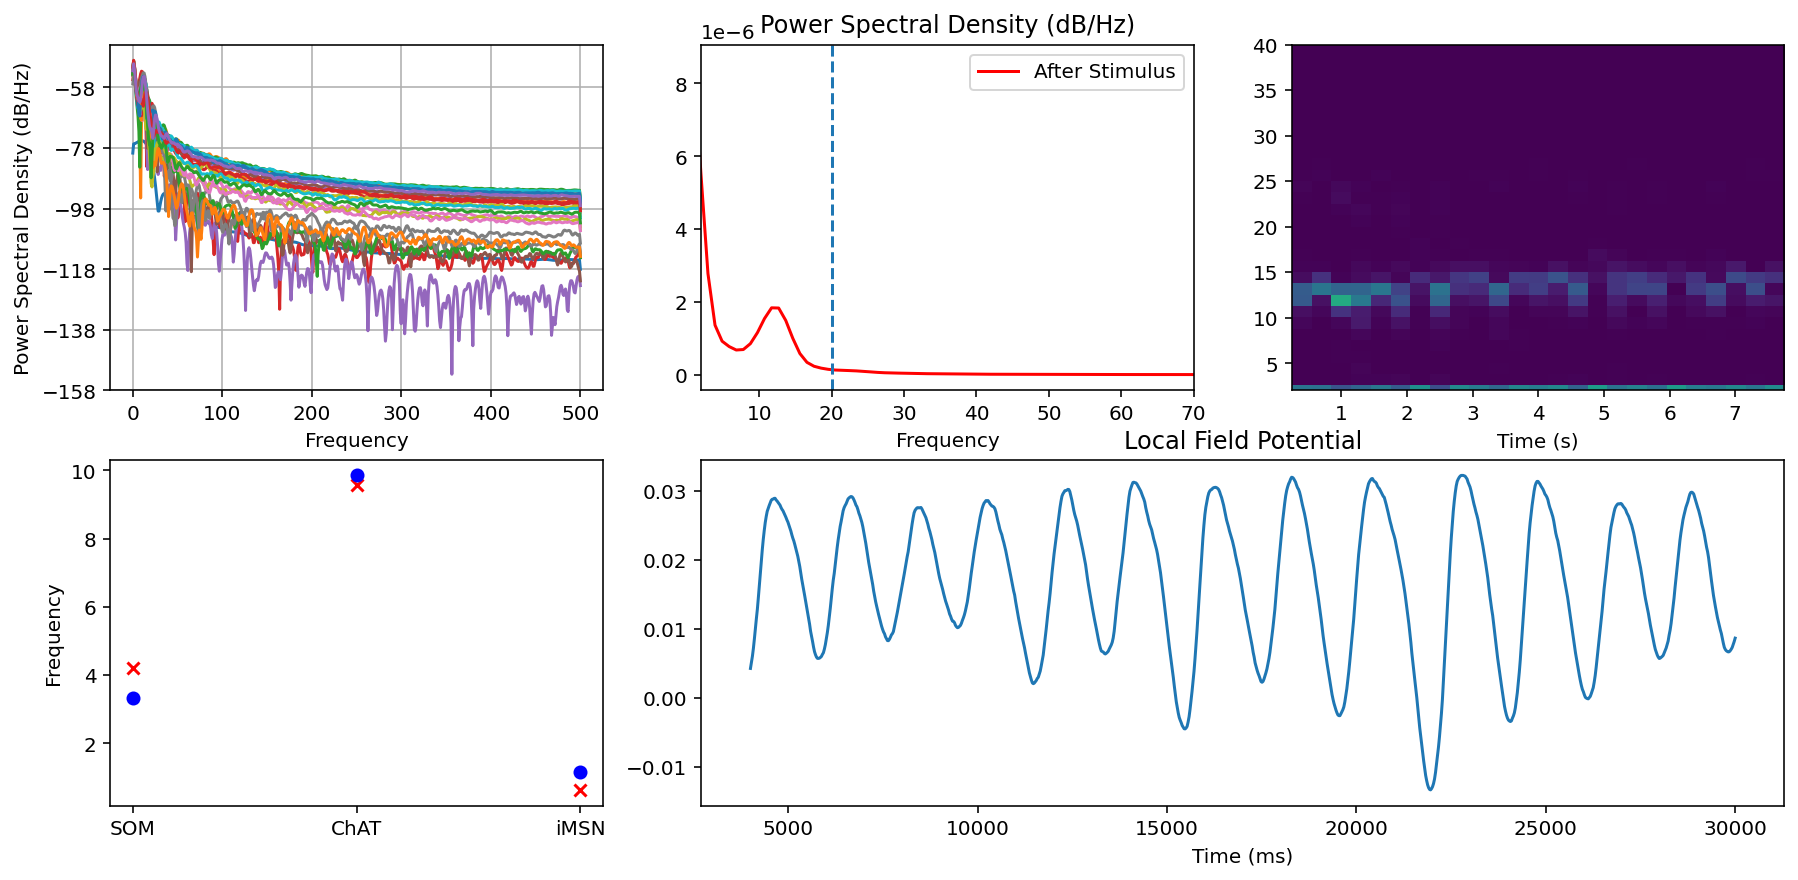

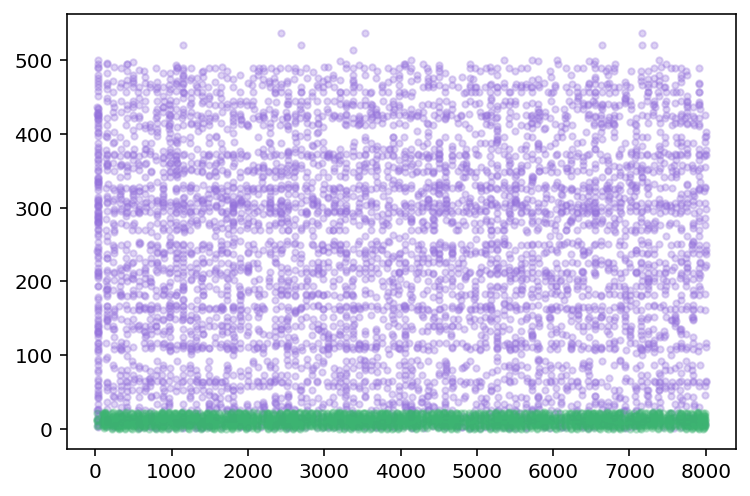

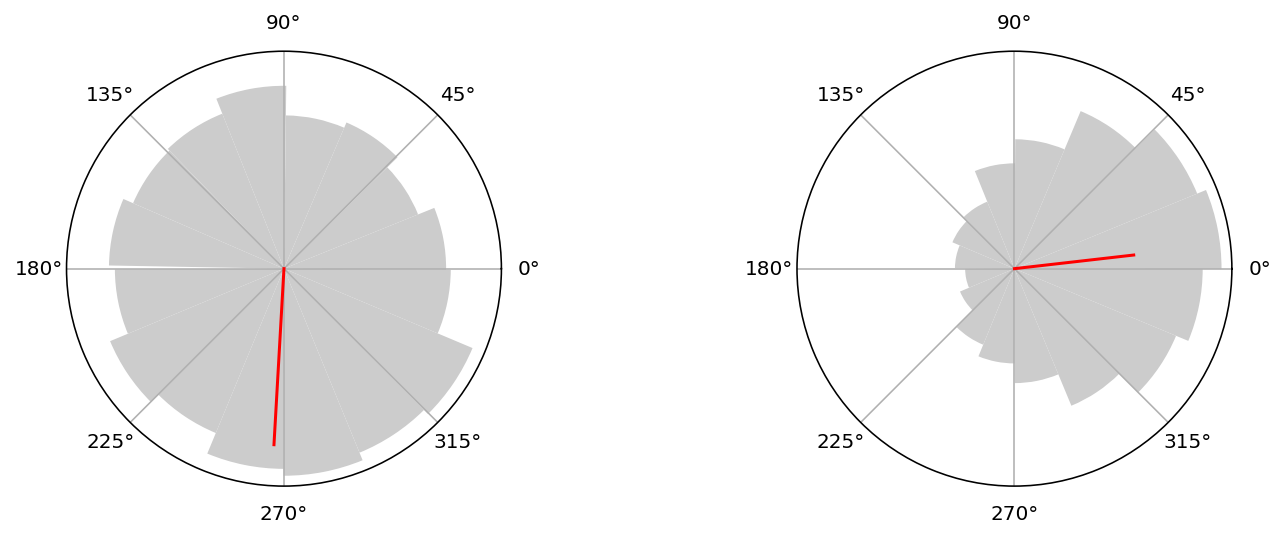

In [29]:
ChAT_phase_inhSOM_nochat,iMSN_phases_inhSOM_nochat,record_ChAT_phases_inhSOM_nochat, record_iMSN_phases_inhSOM_nochat, ChAT_spd_inhSOM_nochat, iMSN_spd_inhSOM_nochat, LFP_inhSOM_nochat, beta_LFP_inhSOM_nochat, allChAT_spd_inhSOM_nochat, allMSN_spd_inhSOM_nochat, all_ChATv_phases_inhSOM_nochat, all_iMSN_phases_inhSOM_nochat,freqs_inhSOM_nochat, pxx2_mean_inhSOM_nochat, rates_inhSOM_nochat,ChAT_mean_inhSOM_nochat,iMSN_mean_inhSOM_nochat,ChAT_frequency_inhSOM_nochat,iMSN_frequency_inhSOM_nochat = StimThreeGroupsHist(simu_time=8*1000,stimu_tstart=0*1000, stimu_tend=8*1000, light_SOM = -22.04, pfM = 8000.0 , pfC = 8700.0 ,  pfS = 8200.0, 
    cpCM = 0.0 , cpMC = 0.86 , wCM = 2.04 , wMC = -50.9 , pC = 3.3 , pM = 1.48 , 
    sMC = 3.7 , sMM = 2.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
    cpSM = 0.58 , wSC = -10.8 , wSM = -30.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
    rnum = 500 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
    pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5 ,
    pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
    ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 2.5, iMSN_tau_syn_in = 10.4, seed=1000 )


Apr 17 19:00:08 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Apr 17 19:00:08 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Apr 17 19:00:08 Network::create_rngs_ [Info]: 
    Creating default RNGs

Apr 17 19:00:08 Network::create_grng_ [Info]: 
    Creating new default global RNG

Apr 17 19:00:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Apr 17 19:00:08 NodeManager::prepare_nodes [Info]: 
    Preparing 3056 nodes for simulation.

Apr 17 19:00:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3056
    Simulation time (ms): 8000
    Number of OpenMP threads: 1
    Not using MPI

Apr 17 19:00:31 SimulationManager::run [Info]: 
    Simulation finished.
-2.390604288822754
-0.15195923850925233
[ 3.25      26.995      1.2050885]


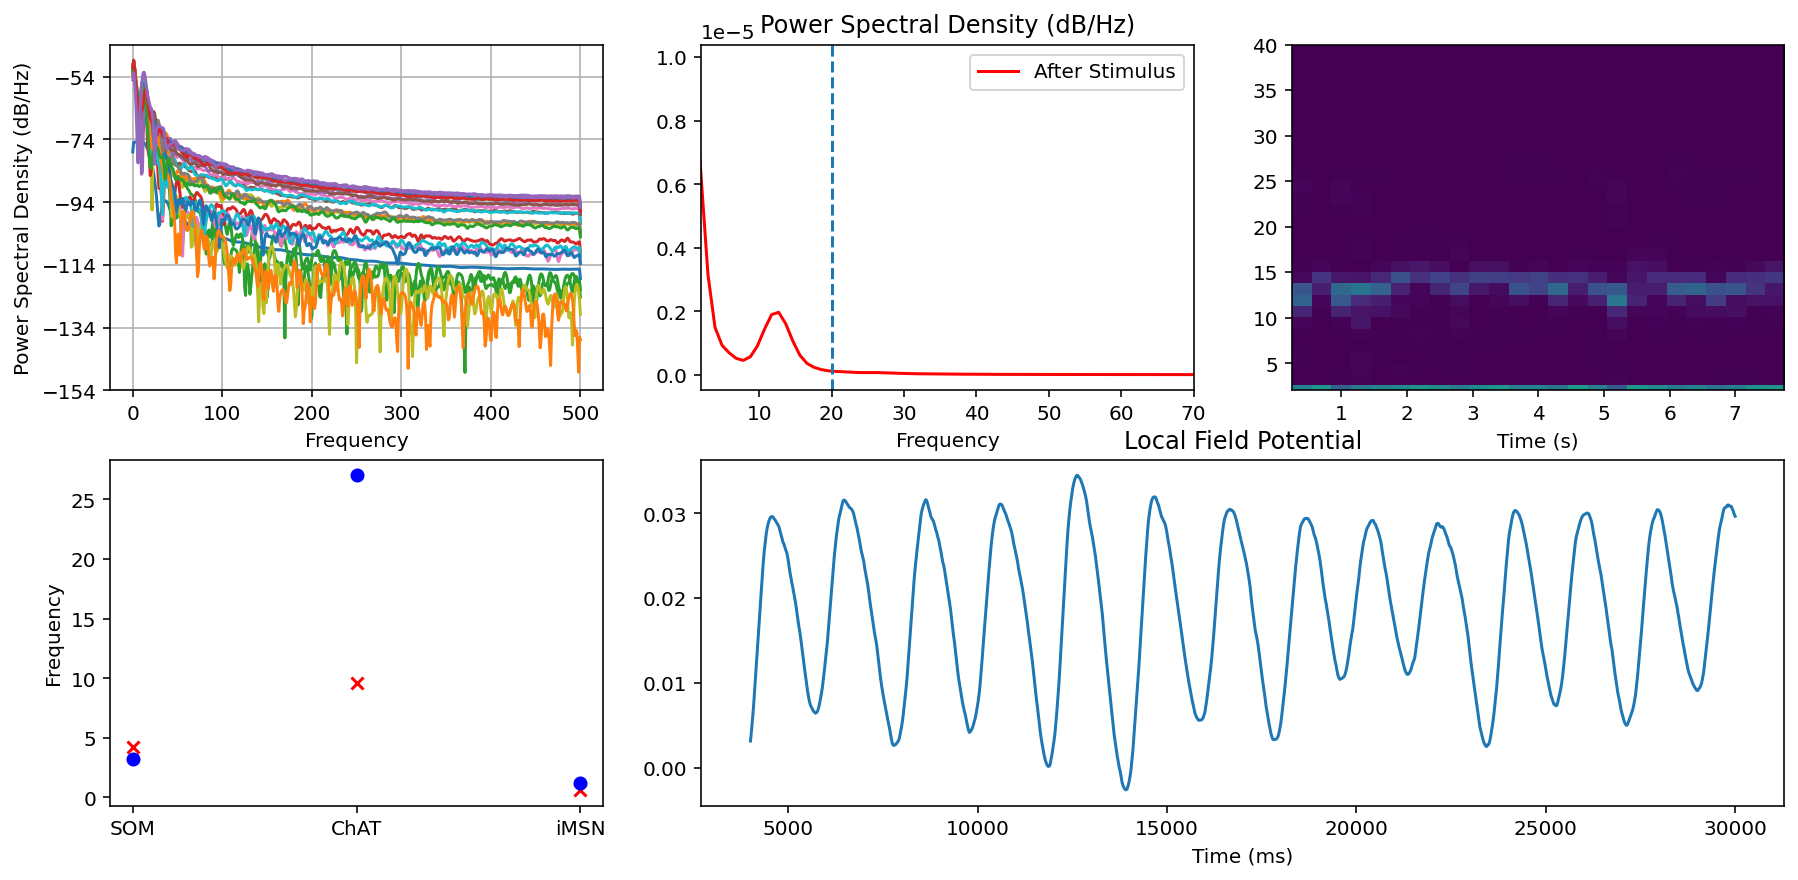

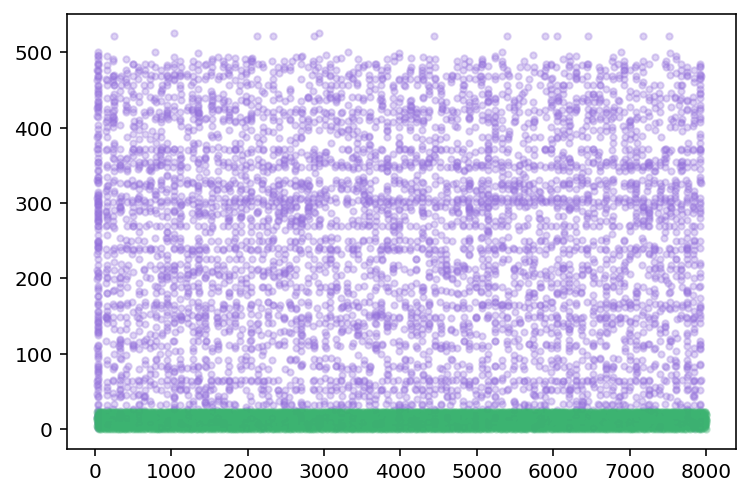

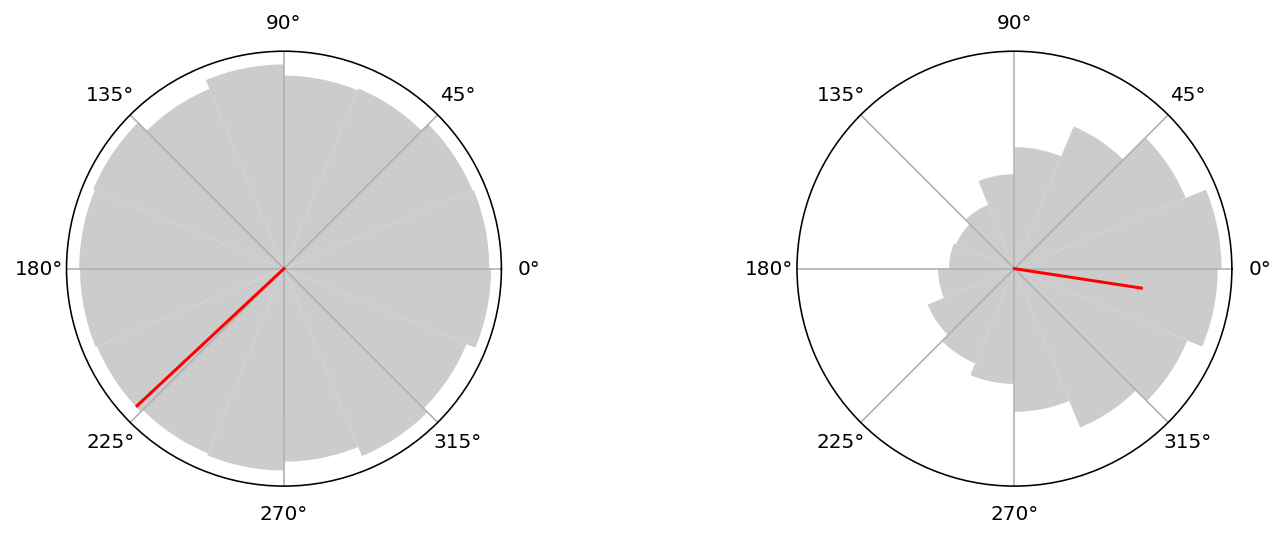

In [30]:
ChAT_phase_inhSOM_nofeedback,iMSN_phases_inhSOM_nofeedback,record_ChAT_phases_inhSOM_nofeedback, record_iMSN_phases_inhSOM_nofeedback, ChAT_spd_inhSOM_nofeedback, iMSN_spd_inhSOM_nofeedback, LFP_inhSOM_nofeedback, beta_LFP_inhSOM_nofeedback, allChAT_spd_inhSOM_nofeedback, allMSN_spd_inhSOM_nofeedback, all_ChATv_phases_inhSOM_nofeedback, all_iMSN_phases_inhSOM_nofeedback,freqs_inhSOM_nofeedback, pxx2_mean_inhSOM_nofeedback, rates_inhSOM_nofeedback,ChAT_mean_inhSOM_nofeedback,iMSN_mean_inhSOM_nofeedback,ChAT_frequency_inhSOM_nofeedback,iMSN_frequency_inhSOM_nofeedback = StimThreeGroupsHist(simu_time=8*1000,stimu_tstart=0*1000, stimu_tend=8*1000, light_SOM = -22.04, pfM = 8000.0 , pfC = 8700.0 ,  pfS = 8200.0, 
    cpCM = 0.44 , cpMC = 0.0 , wCM = 2.04 , wMC = -50.9 , pC = 3.3 , pM = 1.48 , 
    sMC = 3.7 , sMM = 2.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
    cpSM = 0.58 , wSC = -10.8 , wSM = -30.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
    rnum = 500 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
    pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5 ,
    pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
    ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 2.5, iMSN_tau_syn_in = 10.4, seed=1000 )


Apr 15 11:26:01 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Apr 15 11:26:01 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Apr 15 11:26:01 Network::create_rngs_ [Info]: 
    Creating default RNGs

Apr 15 11:26:01 Network::create_grng_ [Info]: 
    Creating new default global RNG

Apr 15 11:26:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Apr 15 11:26:01 NodeManager::prepare_nodes [Info]: 
    Preparing 3056 nodes for simulation.

Apr 15 11:26:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3056
    Simulation time (ms): 40000
    Number of OpenMP threads: 1
    Not using MPI

Apr 15 11:26:50 SimulationManager::run [Info]: 
    Simulation finished.
-1.0767828428801869
0.10118746873495599
[ 3.36875    11.949       0.76606195]


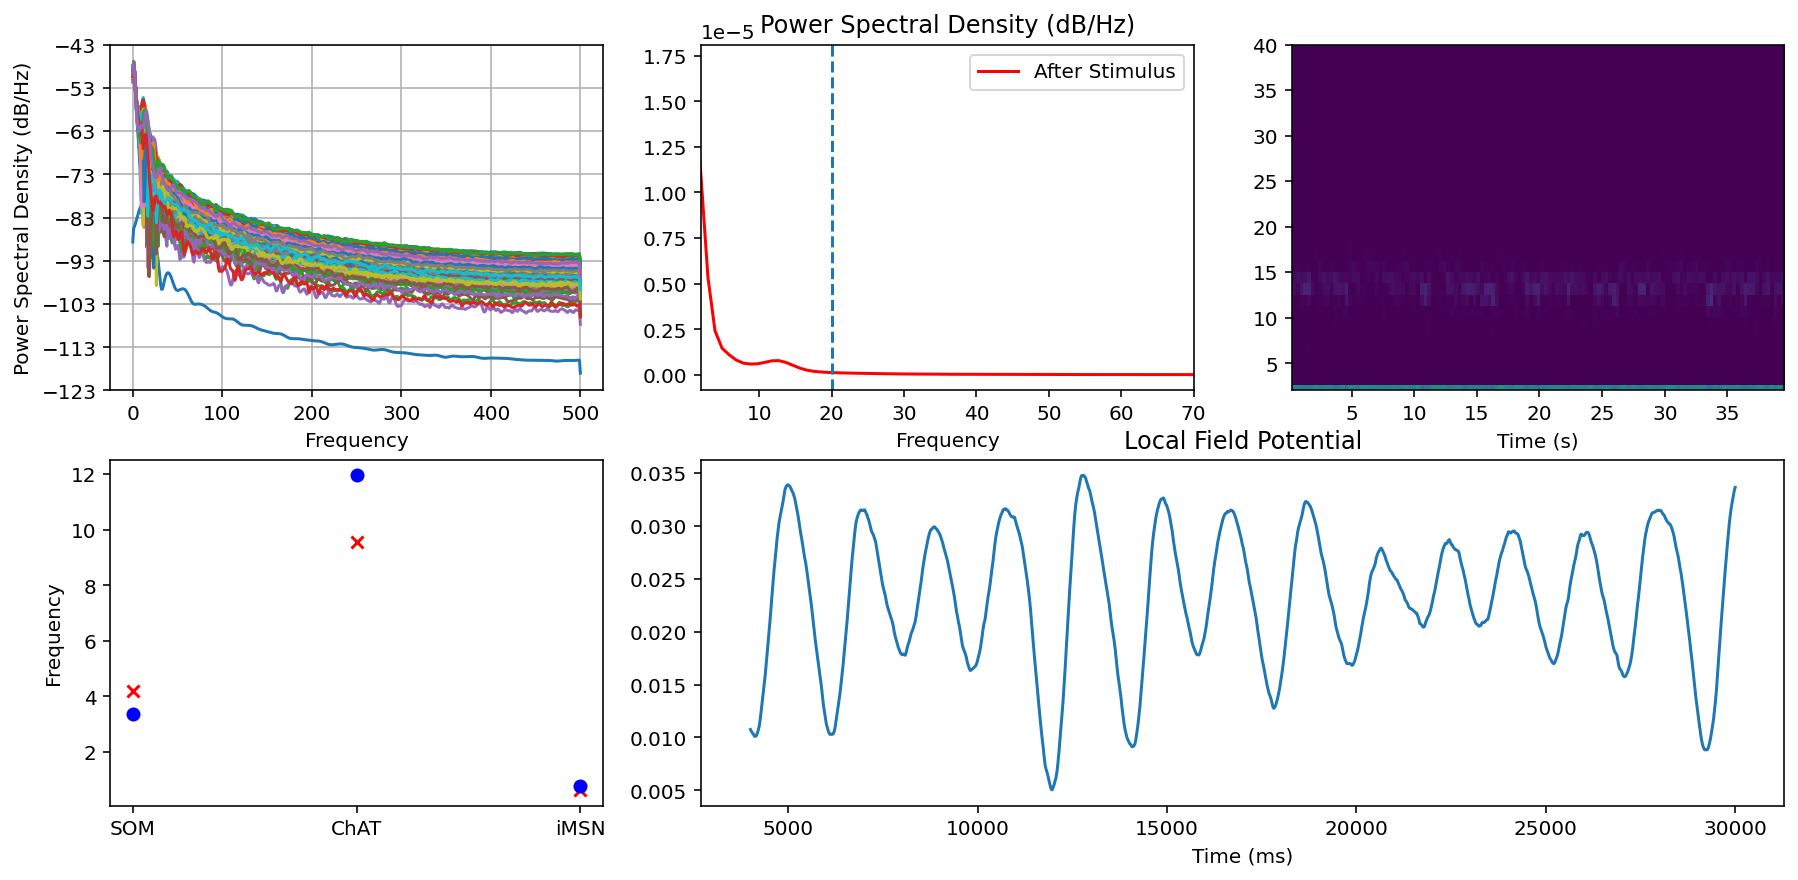

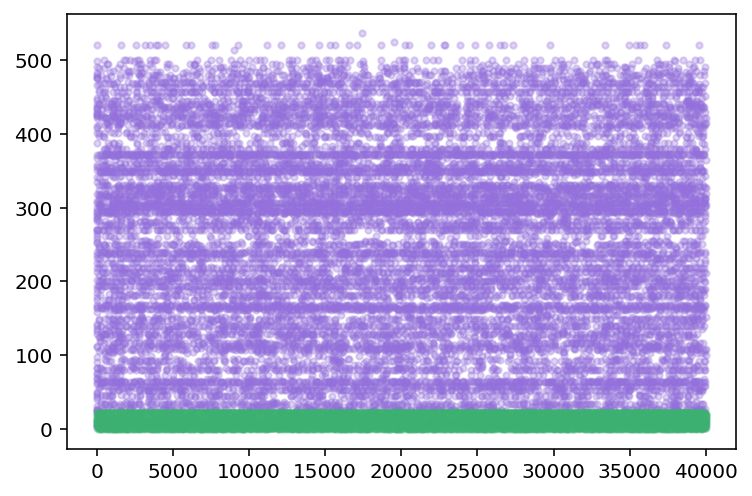

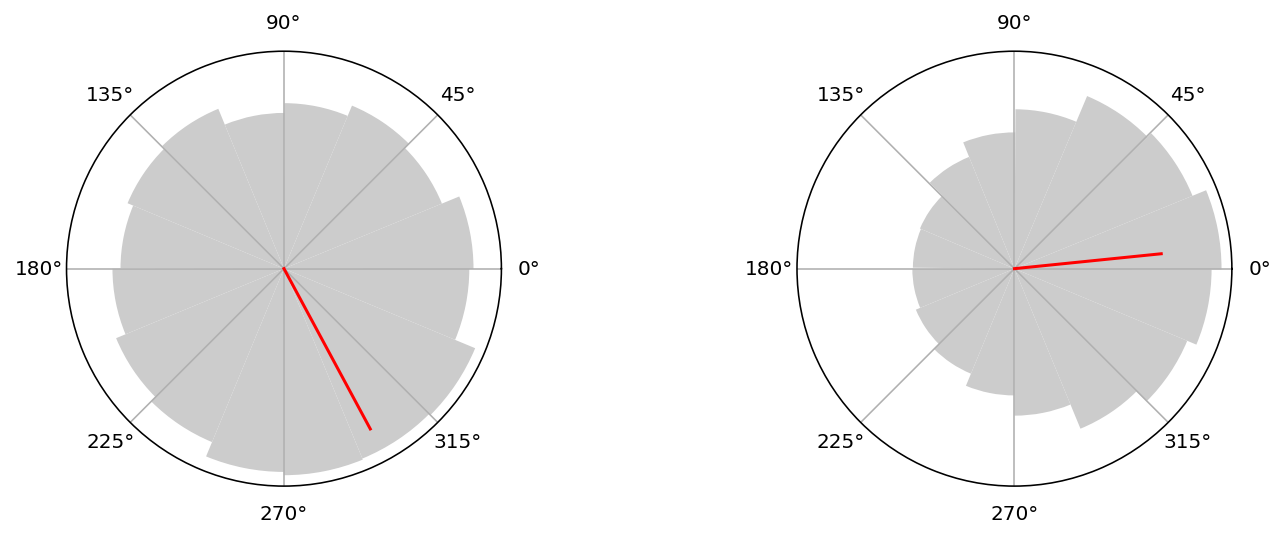

In [24]:
#  the influence of iMSN and ChAT inhibition on the SOM-inhibition-induced beta oscillations
ChAT_phases_inhSOM_inhiMSN,iMSN_phases_inhSOM_inhiMSN,record_ChAT_phases_inhSOM_inhiMSN, record_iMSN_phases_inhSOM_inhiMSN, ChAT_spd_inhSOM_inhiMSN, iMSN_spd_inhSOM_inhiMSN, LFP_inhSOM_inhiMSN, beta_LFP_inhSOM_inhiMSN, allChAT_spd_inhSOM_inhiMSN, allMSN_spd_inhSOM_inhiMSN, all_ChAT_phases_inhSOM_inhiMSN, all_iMSN_phases_inhSOM_inhiMSN,freqs_inhSOM_inhiMSN, pxx2_mean_inhSOM_inhiMSN, rates_inhSOM_inhiMSN,ChAT_mean_inhSOM_inhiMSN,iMSN_mean_inhSOM_inhiMSN,ChAT_frequency_inhSOM_inhiMSN,iMSN_frequency_inhSOM_inhiMSN = StimThreeGroupsHist( simu_time=40*1000, stimu_tstart=0*1000,stimu_tend=40*1000,light_SOM = -22.04, light_iMSN=-10.0, light_ChAT=0.0, pfM = 8000.0 , pfC = 8200.0 ,  pfS = 8200.0, 
    cpCM = 0.44 , cpMC = 0.86 , wCM = 2.04 , wMC = -30.9 , pC = 3.3 , pM = 1.48 , 
    sMC = 3.7 , sMM = 2.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
    cpSM = 0.58 , wSC = -10.8 , wSM = -30.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
    rnum = 500 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
    pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5 ,
    pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
    ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 2.5, iMSN_tau_syn_in = 10.4, seed=1000 )


Apr 15 11:27:13 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Apr 15 11:27:13 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Apr 15 11:27:13 Network::create_rngs_ [Info]: 
    Creating default RNGs

Apr 15 11:27:13 Network::create_grng_ [Info]: 
    Creating new default global RNG

Apr 15 11:27:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Apr 15 11:27:13 NodeManager::prepare_nodes [Info]: 
    Preparing 3056 nodes for simulation.

Apr 15 11:27:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3056
    Simulation time (ms): 40000
    Number of OpenMP threads: 1
    Not using MPI

Apr 15 11:28:03 SimulationManager::run [Info]: 
    Simulation finished.
-2.1459639331710054
-0.0870280080069465
[3.36875    7.004      1.21057522]


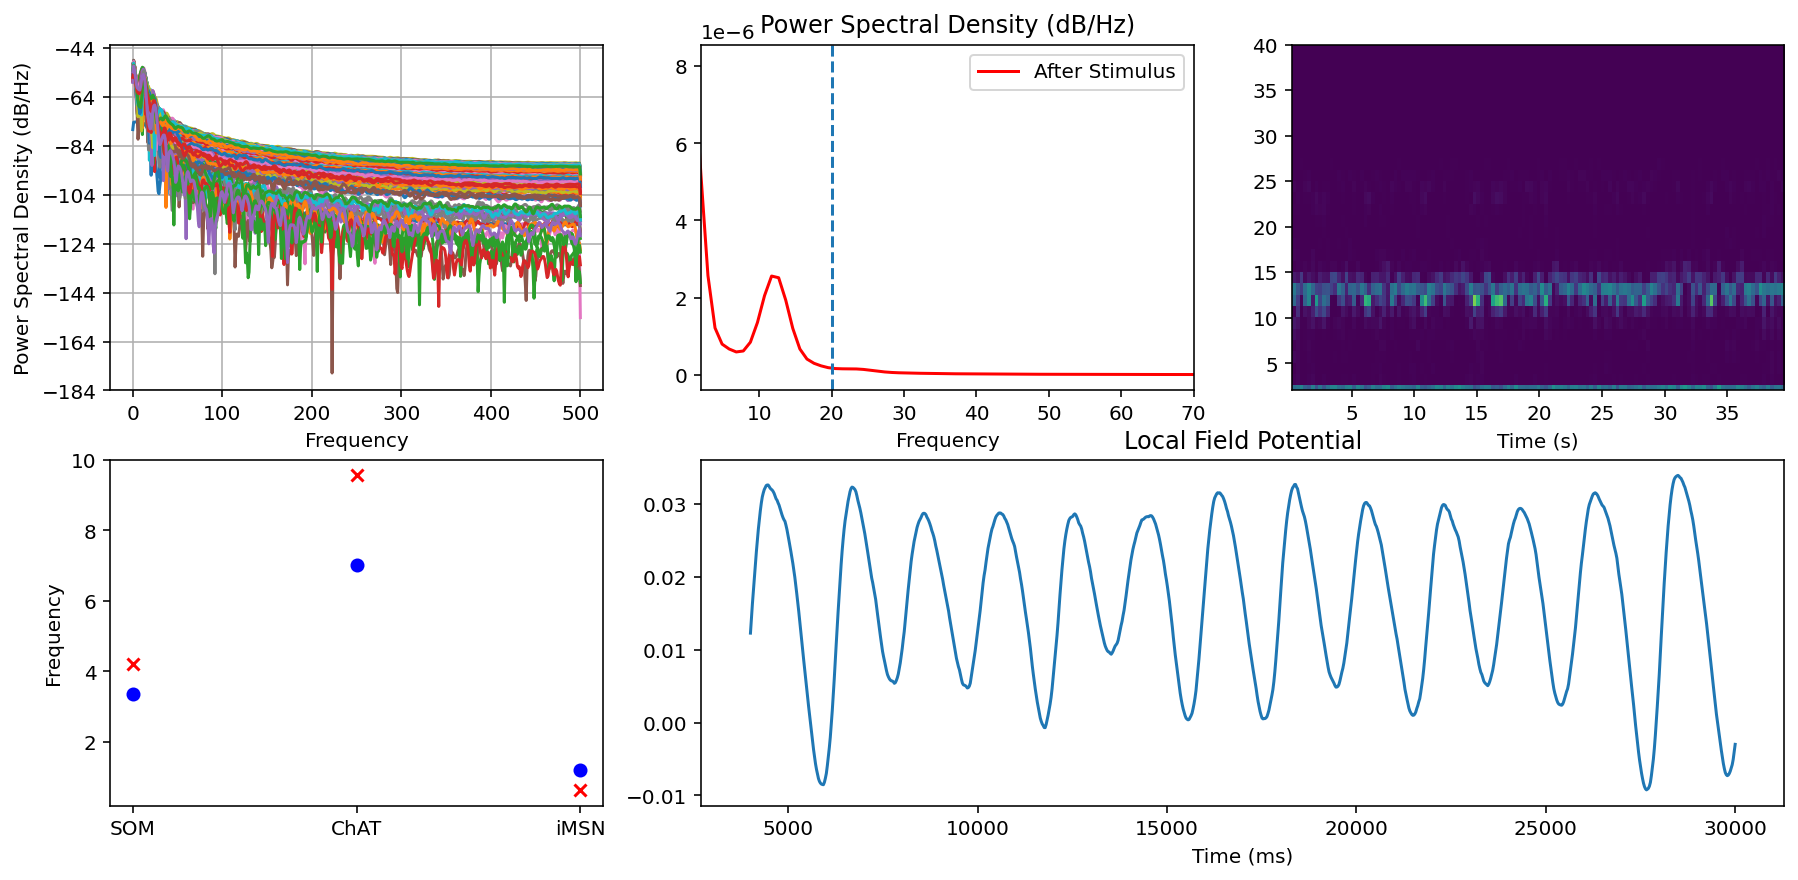

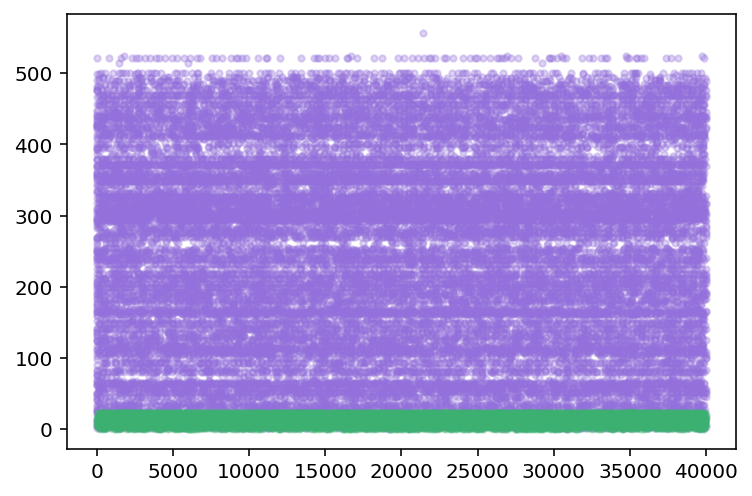

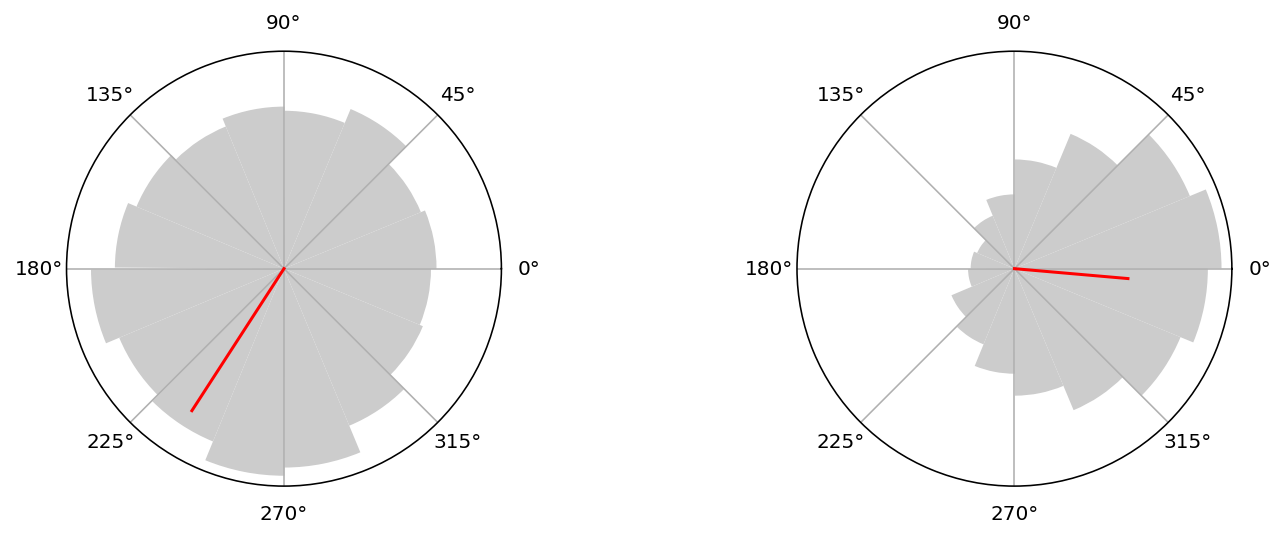

In [25]:
#  the influence of iMSN and ChAT inhibition on the SOM-inhibition-induced beta oscillations
ChAT_phases_inhSOM_inhChAT,iMSN_phases_inhSOM_inhChAT,record_ChAT_phases_inhSOM_inhChAT, record_iMSN_phases_inhSOM_inhChAT, ChAT_spd_inhSOM_inhChAT, iMSN_spd_inhSOM_inhChAT, LFP_inhSOM_inhChAT, beta_LFP_inhSOM_inhChAT, allChAT_spd_inhSOM_inhChAT, allMSN_spd_inhSOM_inhChAT, all_ChAT_phases_inhSOM_inhChAT, all_iMSN_phases_inhSOM_inhChAT,freqs_inhSOM_inhChAT, pxx2_mean_inhSOM_inhChAT, rates_inhSOM_inhChAT,ChAT_mean_inhSOM_inhChAT,iMSN_mean_inhSOM_inhChAT,ChAT_frequency_inhSOM_inhChAT,iMSN_frequency_inhSOM_inhChAT = StimThreeGroupsHist( simu_time=40*1000, stimu_tstart=0*1000,stimu_tend=40*1000,light_SOM = -22.04, light_iMSN=0.0, light_ChAT=-10.0, pfM = 8000.0 , pfC = 8200.0 ,  pfS = 8200.0, 
    cpCM = 0.44 , cpMC = 0.86 , wCM = 2.04 , wMC = -30.9 , pC = 3.3 , pM = 1.48 , 
    sMC = 3.7 , sMM = 2.4 , sCC= 3.95 , sCM = 0.85 ,  sSS = 2.55 , sSC= 3.1 , sSM = 10.05 , cpSC = 0.58 , 
    cpSM = 0.58 , wSC = -10.8 , wSM = -30.6 ,upfilter = 36 , cpMM = 0.5 , amp = 1.9 , 
    rnum = 500 ,wMM = -11.55 , mtcM = 31.34 , capM = 102.0 ,wpfS = 1.59 , sig = 14.7 , 
    pfSin =  100.0 , wpfSin =  -1.0 , pfCin =  100.0 , wpfCin =  -5.5 ,
    pfMin =  70.0 , wpfMin =  -4.0 , cpCC =  0.48, SOM_tau_syn_ex = 3.5, SOM_tau_syn_in = 5.0,
    ChAT_tau_syn_ex = 2.5, ChAT_tau_syn_in = 2.5, iMSN_tau_syn_ex = 2.5, iMSN_tau_syn_in = 10.4, seed=1000 )

In [15]:
# plot the phase lock 
font2={'family':'Times New Roman',
'weight':'bold',
'size': 14}
def plot_phase_lock(ChAT_phases,iMSN_phases):
    fig, axs = plt.subplots(1,2, subplot_kw = dict(projection = 'polar'),figsize=(12,5))
    bins=16
    # ChAT
    phase_mean0 = np.angle(np.exp(ChAT_phases * 1j).mean())
    fre0, bins0 = np.histogram(ChAT_phases, bins=bins)
    widths0 = np.diff(bins0)
    radius0 = fre0
    patches=axs[0].bar(bins0[:-1], radius0, zorder=1, align='edge', width=widths0, color='mediumseagreen',alpha=0.6,
                      edgecolor = None,  linewidth=1)
   
    theta0 = [phase_mean0, phase_mean0]
    r0 = [0, radius0.mean()]
    axs[0].plot(theta0, r0,'k',linewidth=2)
    axs[0].set_xticks(np.arange(0,2*np.pi,1/6*np.pi))
    axs[0].set_yticks(np.arange(100,300,100))
    axs[0].set_ylim([0,300])
    # iMSN
    phase_mean1 = np.angle(np.exp(iMSN_phases * 1j).mean())
    fre1, bins1 = np.histogram(iMSN_phases, bins=bins)
    widths1 = np.diff(bins1)
    radius1 = fre1
    patches=axs[1].bar(bins1[:-1], radius1, zorder=1, align='edge', width=widths1, color='mediumpurple',alpha=0.6,
                      edgecolor = None,  linewidth=1)
   
    theta1 = [phase_mean1, phase_mean1]
    r1 = [0, radius1.mean()]
    axs[1].plot(theta1, r1,'k',linewidth=2)
    axs[1].set_xticks(np.arange(0,2*np.pi,1/6*np.pi))
    axs[1].set_yticks(np.arange(100,300,100))
    axs[1].set_ylim([0,300])
    # plt.savefig('phase_lock_ON.eps')
    # axs[1].set_yticks(np.arange(100,400,100))
    # axs[1].set_ylim([0,300])
    # plt.savefig('phase_lock_OFF.eps')

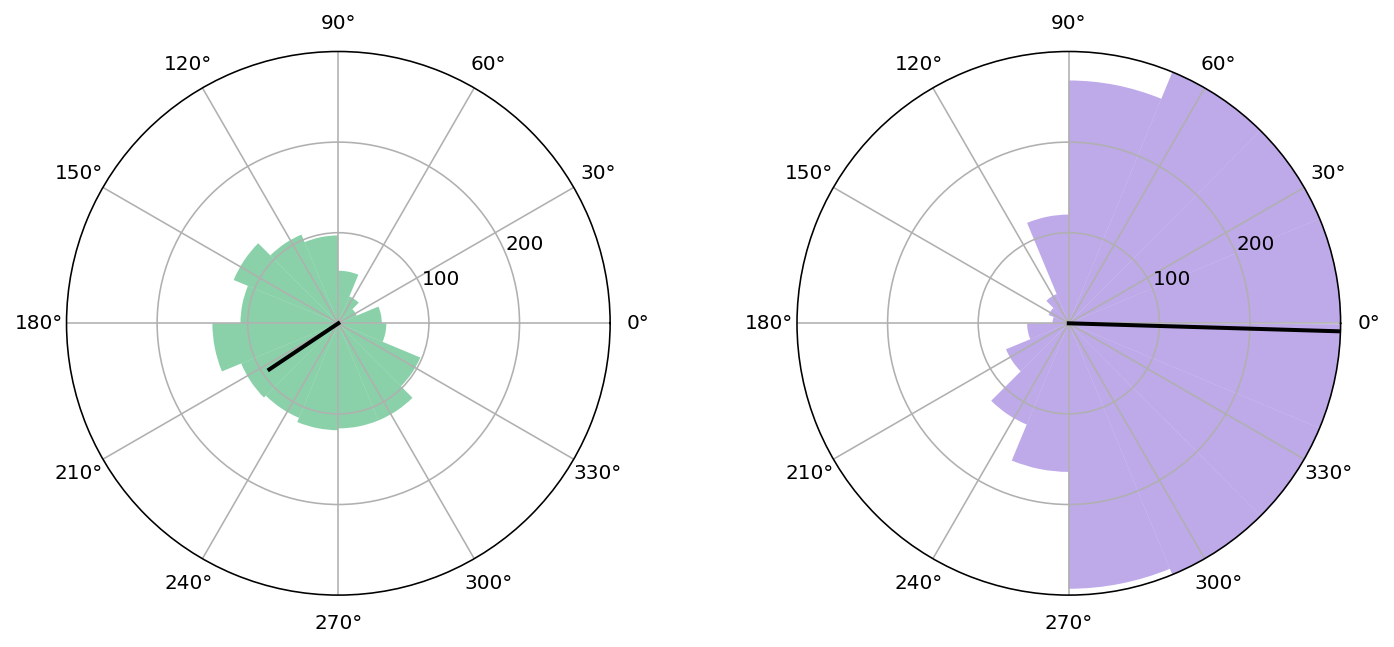

In [26]:
# phase-locking
plot_phase_lock(ChAT_phases_inhSOM,iMSN_phases_inhSOM)
# plot_phase_lock(ChAT_phases_spon,iMSN_phases_spon)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


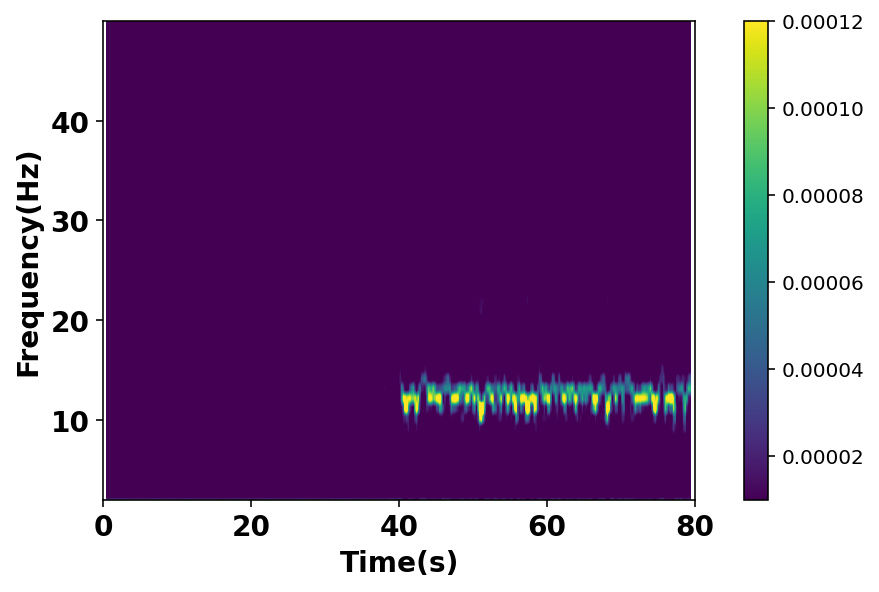

In [28]:
# power
# time frequency figure
font2={'family':'Times New Roman',
'weight':'bold',
'size': 14}
dt=0.001
fig, ax2 = plt.subplots(1,1,constrained_layout=True)
psm = ax2.specgram(LFP_inhSOM1, NFFT = 1024,Fs = 1./dt, scale = 'linear' ,
                                      scale_by_freq = True, noverlap = 800,vmin=10e-6,vmax=120e-6)
cb=fig.colorbar(psm[3], ax=ax2)
# cb.ax.tick_params(labelsize=14)
ax2.set_xlabel('Time(s)',font1)
ax2.set_ylabel('Frequency(Hz)',font1)
ax2.set_xticks(np.arange(0,100,20))
ax2.set_yticks(np.arange(10,50,10))
ax2.set_xticklabels(np.arange(0,100,20),fontsize=14,weight='bold')
ax2.set_yticklabels(np.arange(10,50,10),fontsize=14,weight='bold')
# ax2.set_xlim([0.3,50])
ax2.set_ylim([2,50])
# ax2.set_title('tau_iM=10.4ms, sMM=2.4ms')
# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.legend(loc='best',prop=font1,edgecolor='white')
plt.savefig('inhSOM_time_power_spectrum.eps')

# power spectrum 
font2={'family':'Times New Roman',
'weight':'bold',
'size': 14}
fig = plt.figure(figsize=(5,4)) 
gs = gridspec.GridSpec(1, 1)
ax2=plt.subplot(gs[0]) 
ax2.plot(freqs_spon, pxx2_mean_spon*1e6,'k',label='Spontaneous')
ax2.plot(freqs_inhSOM, pxx2_mean_inhSOM*1e6,'r',label = 'SOM inhibition')
# ax2.plot(freqs_inhDA, pxx2_mean_inhDA*1e6,'r',label = 'DAN inhibition')
ax2.set_xlabel('Frequency(Hz)',font1)
ax2.set_ylabel(r'Power ($\times 10^{-6}$ MV^2)',font1)
ax2.set_xticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(0,10,2))
ax2.set_xticklabels(np.arange(0,60,10),fontsize=14,weight='bold')
ax2.set_yticklabels(np.arange(0,10,2),fontsize=14,weight='bold')
ax2.set_xlim([2,50])
ax2.set_ylim([0,8])
# ax2.set_title('tau_iM=10.4ms, sMM=2.4ms')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend(loc='best',prop=font1,edgecolor='white')
plt.savefig('spon_inhSOM_power.eps')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


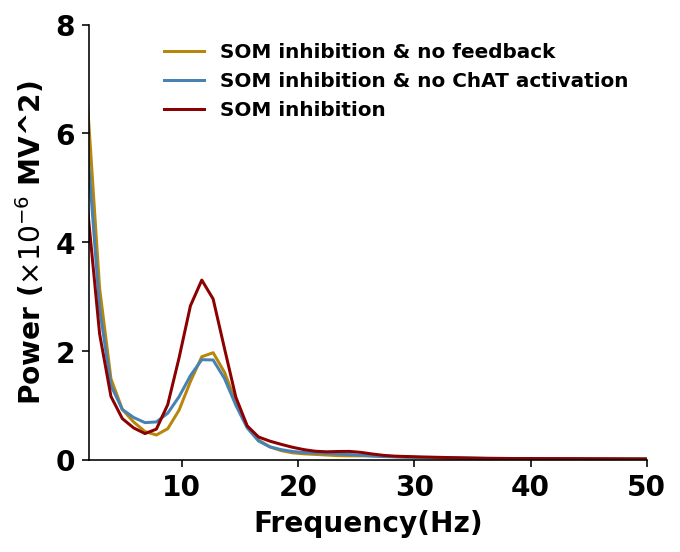

In [31]:
# the role of different connection
# power spectrum 
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
fig = plt.figure(figsize=(5,4)) 
gs = gridspec.GridSpec(1, 1)
ax2=plt.subplot(gs[0]) 
ax2.plot(freqs_inhSOM_nofeedback, pxx2_mean_inhSOM_nofeedback*1e6,color='darkgoldenrod',label='SOM inhibition & no feedback')
ax2.plot(freqs_inhSOM_nochat, pxx2_mean_inhSOM_nochat*1e6,color='steelblue',label='SOM inhibition & no ChAT activation')
# ax2.plot(freqs_spon, pxx2_mean_spon*1e6,'k',label='Spontaneous')
ax2.plot(freqs_inhSOM, pxx2_mean_inhSOM*1e6,color='darkred',label = 'SOM inhibition')
# ax2.plot(freqs_inhDA, pxx2_mean_inhDA*1e6,'r',label = 'DAN inhibition')
ax2.set_xlabel('Frequency(Hz)',font1)
ax2.set_ylabel(r'Power ($\times 10^{-6}$ MV^2)',font1)
ax2.set_xticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(0,10,2))
ax2.set_xticklabels(np.arange(0,60,10),fontsize=14,weight='bold')
ax2.set_yticklabels(np.arange(0,10,2),fontsize=14,weight='bold')
ax2.set_xlim([2,50])
ax2.set_ylim([0,8])
# ax2.set_title('tau_iM=10.4ms, sMM=2.4ms')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend(loc='best',prop=font2,edgecolor='white')
plt.savefig('inhSOM_role_connection_power.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


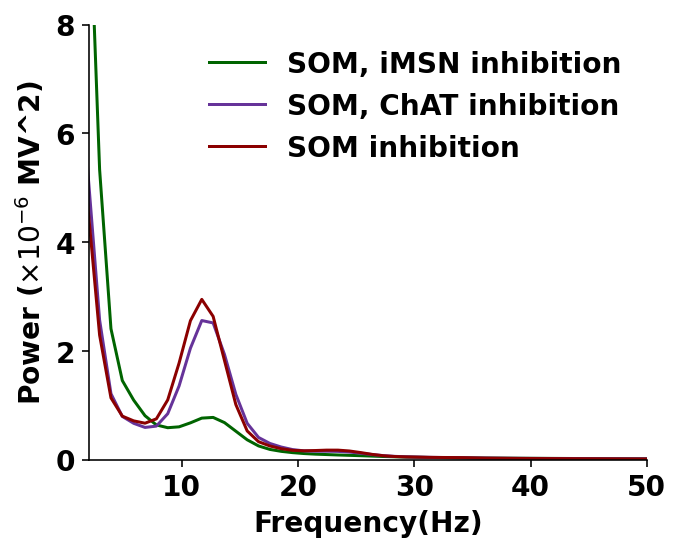

In [29]:
# the change of power when inhibiting iMSN/ChAT
# power spectrum 
font2={'family':'Times New Roman',
'weight':'bold',
'size': 14}
fig = plt.figure(figsize=(5,4)) 
gs = gridspec.GridSpec(1, 1)
ax2=plt.subplot(gs[0]) 
ax2.plot(freqs_inhSOM_inhiMSN, pxx2_mean_inhSOM_inhiMSN*1e6,color='darkgreen',label='SOM, iMSN inhibition')
ax2.plot(freqs_inhSOM_inhChAT, pxx2_mean_inhSOM_inhChAT*1e6,color='rebeccapurple',label='SOM, ChAT inhibition')
ax2.plot(freqs_inhSOM, pxx2_mean_inhSOM*1e6,'darkred',label = 'SOM inhibition')
ax2.set_xlabel('Frequency(Hz)',font1)
ax2.set_ylabel(r'Power ($\times 10^{-6}$ MV^2)',font1)
ax2.set_xticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(0,10,2))
ax2.set_xticklabels(np.arange(0,60,10),fontsize=14,weight='bold')
ax2.set_yticklabels(np.arange(0,10,2),fontsize=14,weight='bold')
ax2.set_xlim([2,50])
ax2.set_ylim([0,8])
# ax2.set_title('tau_iM=10.4ms, sMM=2.4ms')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend(loc='best',prop=font1,edgecolor='white')
plt.savefig('inhSOM_inhiMSN_ChAT_power_spectrum.eps')